### Importing Libraries

In [65]:
import pandas as pd 
import numpy as np 
from ultralytics import YOLO 
import cv2
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import random
import torch
import shutil
from IPython.display import Image, display

### Setting up the image paths

In [43]:
base_path = '../data'
image_path = base_path + '/Images'
label_path = base_path + '/Labels'

data_path = base_path + '/data.yaml'


device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [44]:
def convert_to_yolo(image_path, label_path):
    image_files = sorted(os.listdir(image_path))
    label_files = sorted(os.listdir(label_path))
    for file in image_files: 
        image_paths = os.path.join(image_path, file)
        image = cv2.imread(image_paths)
        h, w, _ = image.shape

        label_paths = os.path.join(label_path, file[:-4] + "txt")
        yolo_labels = []
        f = open(label_paths, "r")
        lines = f.readlines()
        for line in lines[1:]:
            line = line.strip().split()
            x_min, y_min, x_max, y_max = int(line[0]), int(line[1]), int(line[2]), int(line[3])

            x_center = (x_min + x_max)/(2 * w)
            y_center = (y_min + y_max)/(2 * h)
            width = (x_max - x_min)/w
            height = (y_max - y_min)/h

            yolo_labels.append(f"{x_center} {y_center} {width} {height}\n")
        with open(label_paths, "w") as f:
            f.writelines(yolo_labels)


        



In [45]:
def convert_to_yolo(x_min:int, x_max:int, y_min:int, y_max:int, w:int, h:int):
    x_center = (x_min + x_max)/(2 * w)
    y_center = (y_min + y_max)/(2 * h)
    width = (x_max - x_min)/w
    height = (y_max - y_min)/h
    return x_center,  y_center, width, height

### Creating train and validation splits

In [46]:
def create_splits(current_img_path, destination_path, current_label_path, label_destination,  split_size : float, train : bool = True):
    image_files = sorted(os.listdir(current_img_path))
    label_files = sorted(os.listdir(current_label_path))
    split_idx = int(len(os.listdir(current_img_path)) * 0.8)
    if train: 
        sample = image_files[:split_idx]
        label = label_files[:split_idx]
    else:
        sample = image_files[split_idx:]
        label = label_files[split_idx:]
    print(len(sample))    
    for file in sample: 
        image_path = os.path.join(current_img_path, file)
        image = cv2.imread(image_path)
        h, w, _ = image.shape
        cv2.imwrite(os.path.join(destination_path, file), image)

        label_paths = os.path.join(current_label_path, file[:-4] + "txt")
        f = open(label_paths, "r")
        lines = f.readlines()
        f.close()
            
        f = open(os.path.join(label_destination, file[:-4] + "txt"), "w")

        for line in lines[1: ]:
                line = line.strip().split()
                x_min, y_min, x_max, y_max = int(line[0]), int(line[1]), int(line[2]), int(line[3])
                x_center, y_center, width, height = convert_to_yolo(x_min, x_max, y_min, y_max, w, h)
                f.write("{} {} {} {} {}\n".format(0, x_center, y_center, width, height))


                

In [47]:
train_img_path = '../data/train/images'
train_label_path = '../data/train/labels'
val_img_path = '../data/val/images'
val_label_path = '../data/val/labels'

In [48]:
os.makedirs(train_img_path, exist_ok = True)
os.makedirs(train_label_path, exist_ok = True)
os.makedirs(val_img_path, exist_ok= True)
os.makedirs(val_label_path, exist_ok= True)

In [49]:
create_splits(image_path, train_img_path, label_path, train_label_path, split_size = 0.8, train = True)
create_splits(image_path, val_img_path, label_path, val_label_path, split_size = 0.2, train = False)

266
67


## Exploratory Data Analysis 

Let us visualise some of the properties of the image dataset that we have obtained

In [50]:
len(os.listdir(image_path))   

333

In [51]:
def get_heights_and_widths_of_images(image_path : str):
    heights = []
    widths = []
    img_files = sorted(os.listdir(image_path))
    for file in img_files:
        image = cv2.imread(os.path.join(image_path, file))
        h, w, _ = image.shape
        heights.append(h)
        widths.append(w)

    return heights, widths    



In [52]:
heights, widths = get_heights_and_widths_of_images(image_path)

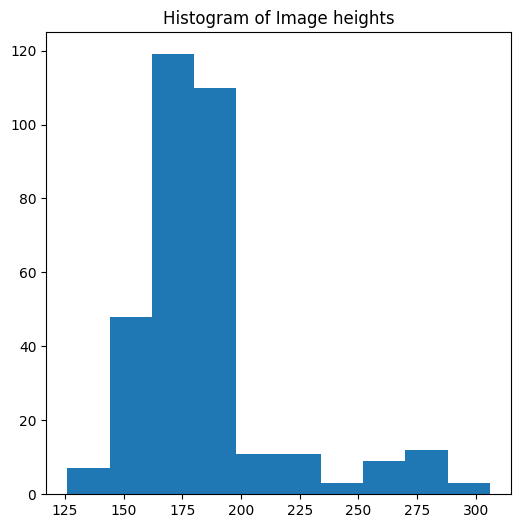

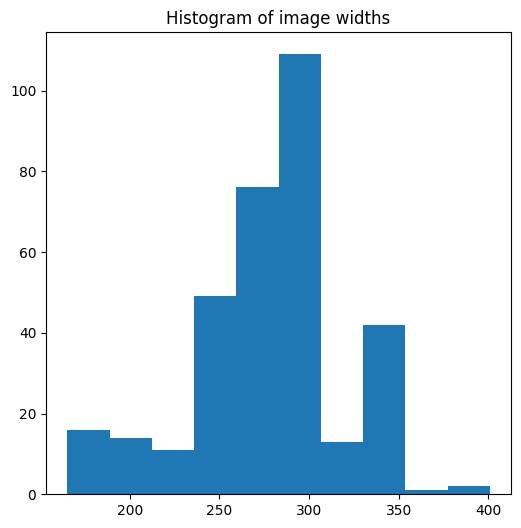

In [53]:
def plot_hist(data : list, title :str | None):
    plt.figure(figsize = (6,6))
    plt.hist(x = data, bins = 10)
    plt.title(title)
    plt.show()

plot_hist(heights, title= "Histogram of Image heights")
plot_hist(widths, title = "Histogram of image widths")

Now let us count the number of instances a gun has been shown across the 333 images

In [54]:
def count_total_objects(label_path):
    total_obj_count = []
    label_files = sorted(os.listdir(label_path))
    for file in label_files:
        labels = os.path.join(label_path, file)
        f = open(labels, "r")
        lines = f.readlines()
        count = int(lines[0])
        total_obj_count.append(count)

    return total_obj_count, sum(total_obj_count)


In [55]:
total_count_list, total_sum = count_total_objects(label_path)

In [56]:
total_sum

428

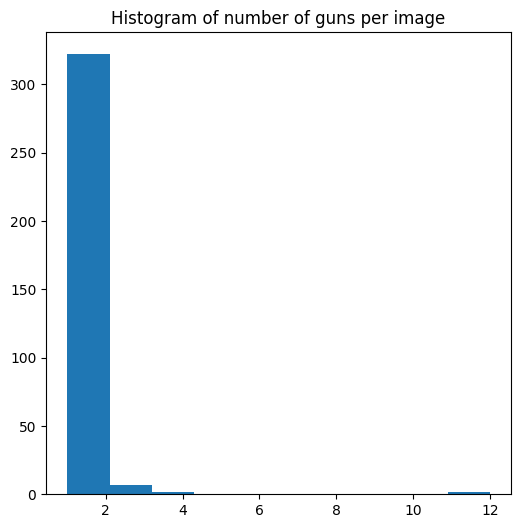

In [57]:
plot_hist(total_count_list, title = 'Histogram of number of guns per image')

In [58]:
def bounding_boxes_measurements(label_path):
    heights = []
    widths = []
    label_files = sorted(os.listdir(label_path))
    for file in label_files:
        labels = os.path.join(label_path, file)
        f = open(labels, "r")
        lines = f.readlines()
        for line in lines[1:]:
            line = line.strip().split()
            x_min, y_min, x_max, y_max = int(line[0]), int(line[1]), int(line[2]), int(line[3])
            widths.append(x_max - x_min)
            heights.append(y_max - y_min)
    return heights, widths


heights, widths = bounding_boxes_measurements(label_path)


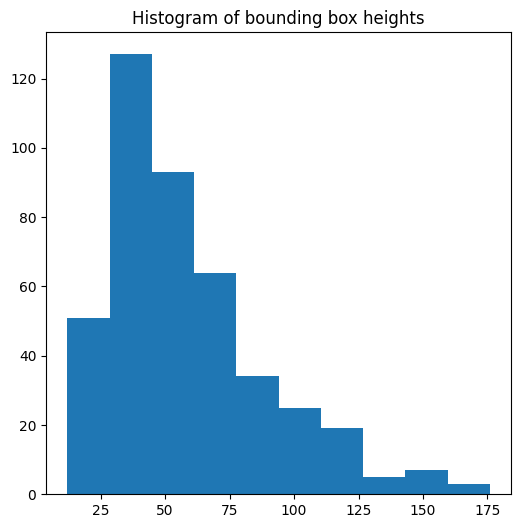

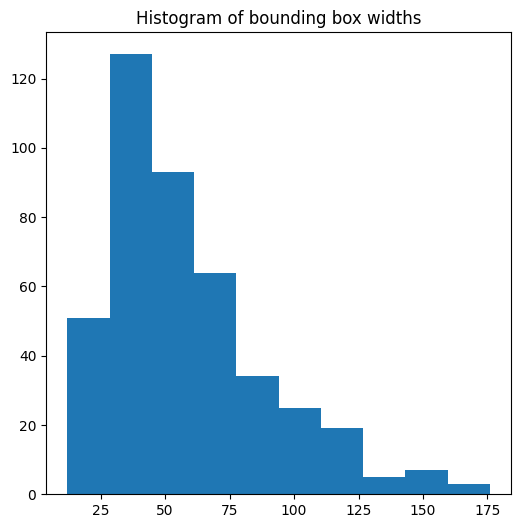

In [59]:
plot_hist(heights, title = 'Histogram of bounding box heights')
plot_hist(heights, title = 'Histogram of bounding box widths')

In [60]:
def images_with_bbox_annots(image_dir, label_dir):
    image_files = sorted(os.listdir(image_dir))

    sample_images = random.sample(image_files, 12)

    fig, axs = plt.subplots(4,3, figsize = (15,20))

    for i, image in enumerate(sample_images):
        image_path = os.path.join(image_dir, image)
        label_path = os.path.join(label_dir, image[:-4] + "txt")
        f = open(label_path)
        lines = f.readlines()

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


        for line in lines[1:]:
            line = line.strip().split()

            x_center, y_center, width, height = float(line[0]), float(line[1]), float(line[2]), float(line[3])

            cv2.rectangle(image, ((x_center - width)/2, (y_center - height/2)), ((x_center + width)/2,(y_center - height/2)), (255,0,0), 2)
            cv2.putText(image,'Gun', ((x_center - width)/2, (y_center - height/2)), cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale = 1, color = (255,255,255), thickness = 3)
        row = i // 3
        col = i % 3

        axs[row, col].imshow(image)
        axs[row, col].axis("off")
    plt.show()

error: OpenCV(4.13.0) :-1: error: (-5:Bad argument) in function 'rectangle'
> Overload resolution failed:
>  - Can't parse 'pt1'. Sequence item with index 0 has a wrong type
>  - Can't parse 'rec'. Expected sequence length 4, got 2
>  - Can't parse 'pt1'. Sequence item with index 0 has a wrong type
>  - Can't parse 'rec'. Expected sequence length 4, got 2


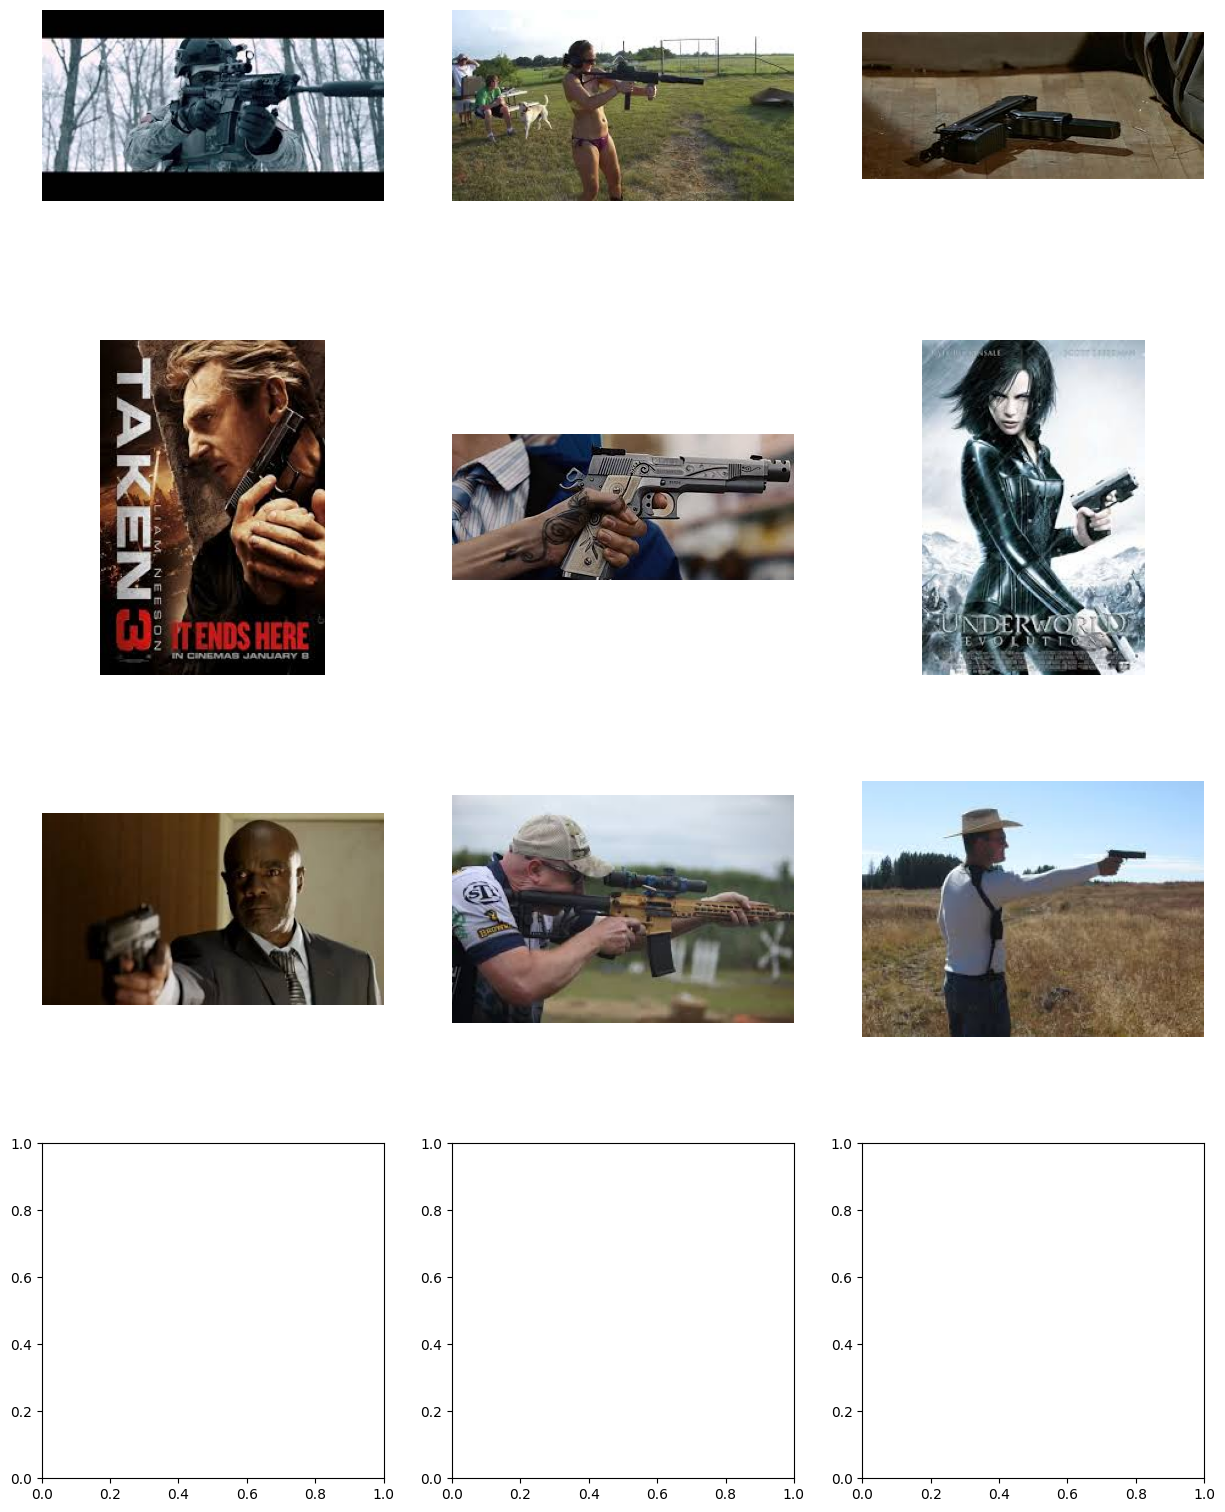

In [21]:
images_with_bbox_annots(image_path, label_path)

## Modelling

Now, let us move into the modelling phase. We will first start with an out of the box YOLO model which should work well if given enough epochs to converge.

In [75]:
model = YOLO("yolo26n.pt", task = 'detect')

In [76]:
results = model.train(data = data_path, epochs = 100, batch = 16, device = device, project='../runs', name='gun_detection')

New https://pypi.org/project/ultralytics/8.4.12 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.4.11 🚀 Python-3.11.9 torch-2.10.0 CPU (Apple M3)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo26n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=gun_detection2, nbs=64, nms=False, opset=None

In [78]:
os.makedirs('../runs/detect', exist_ok=True)

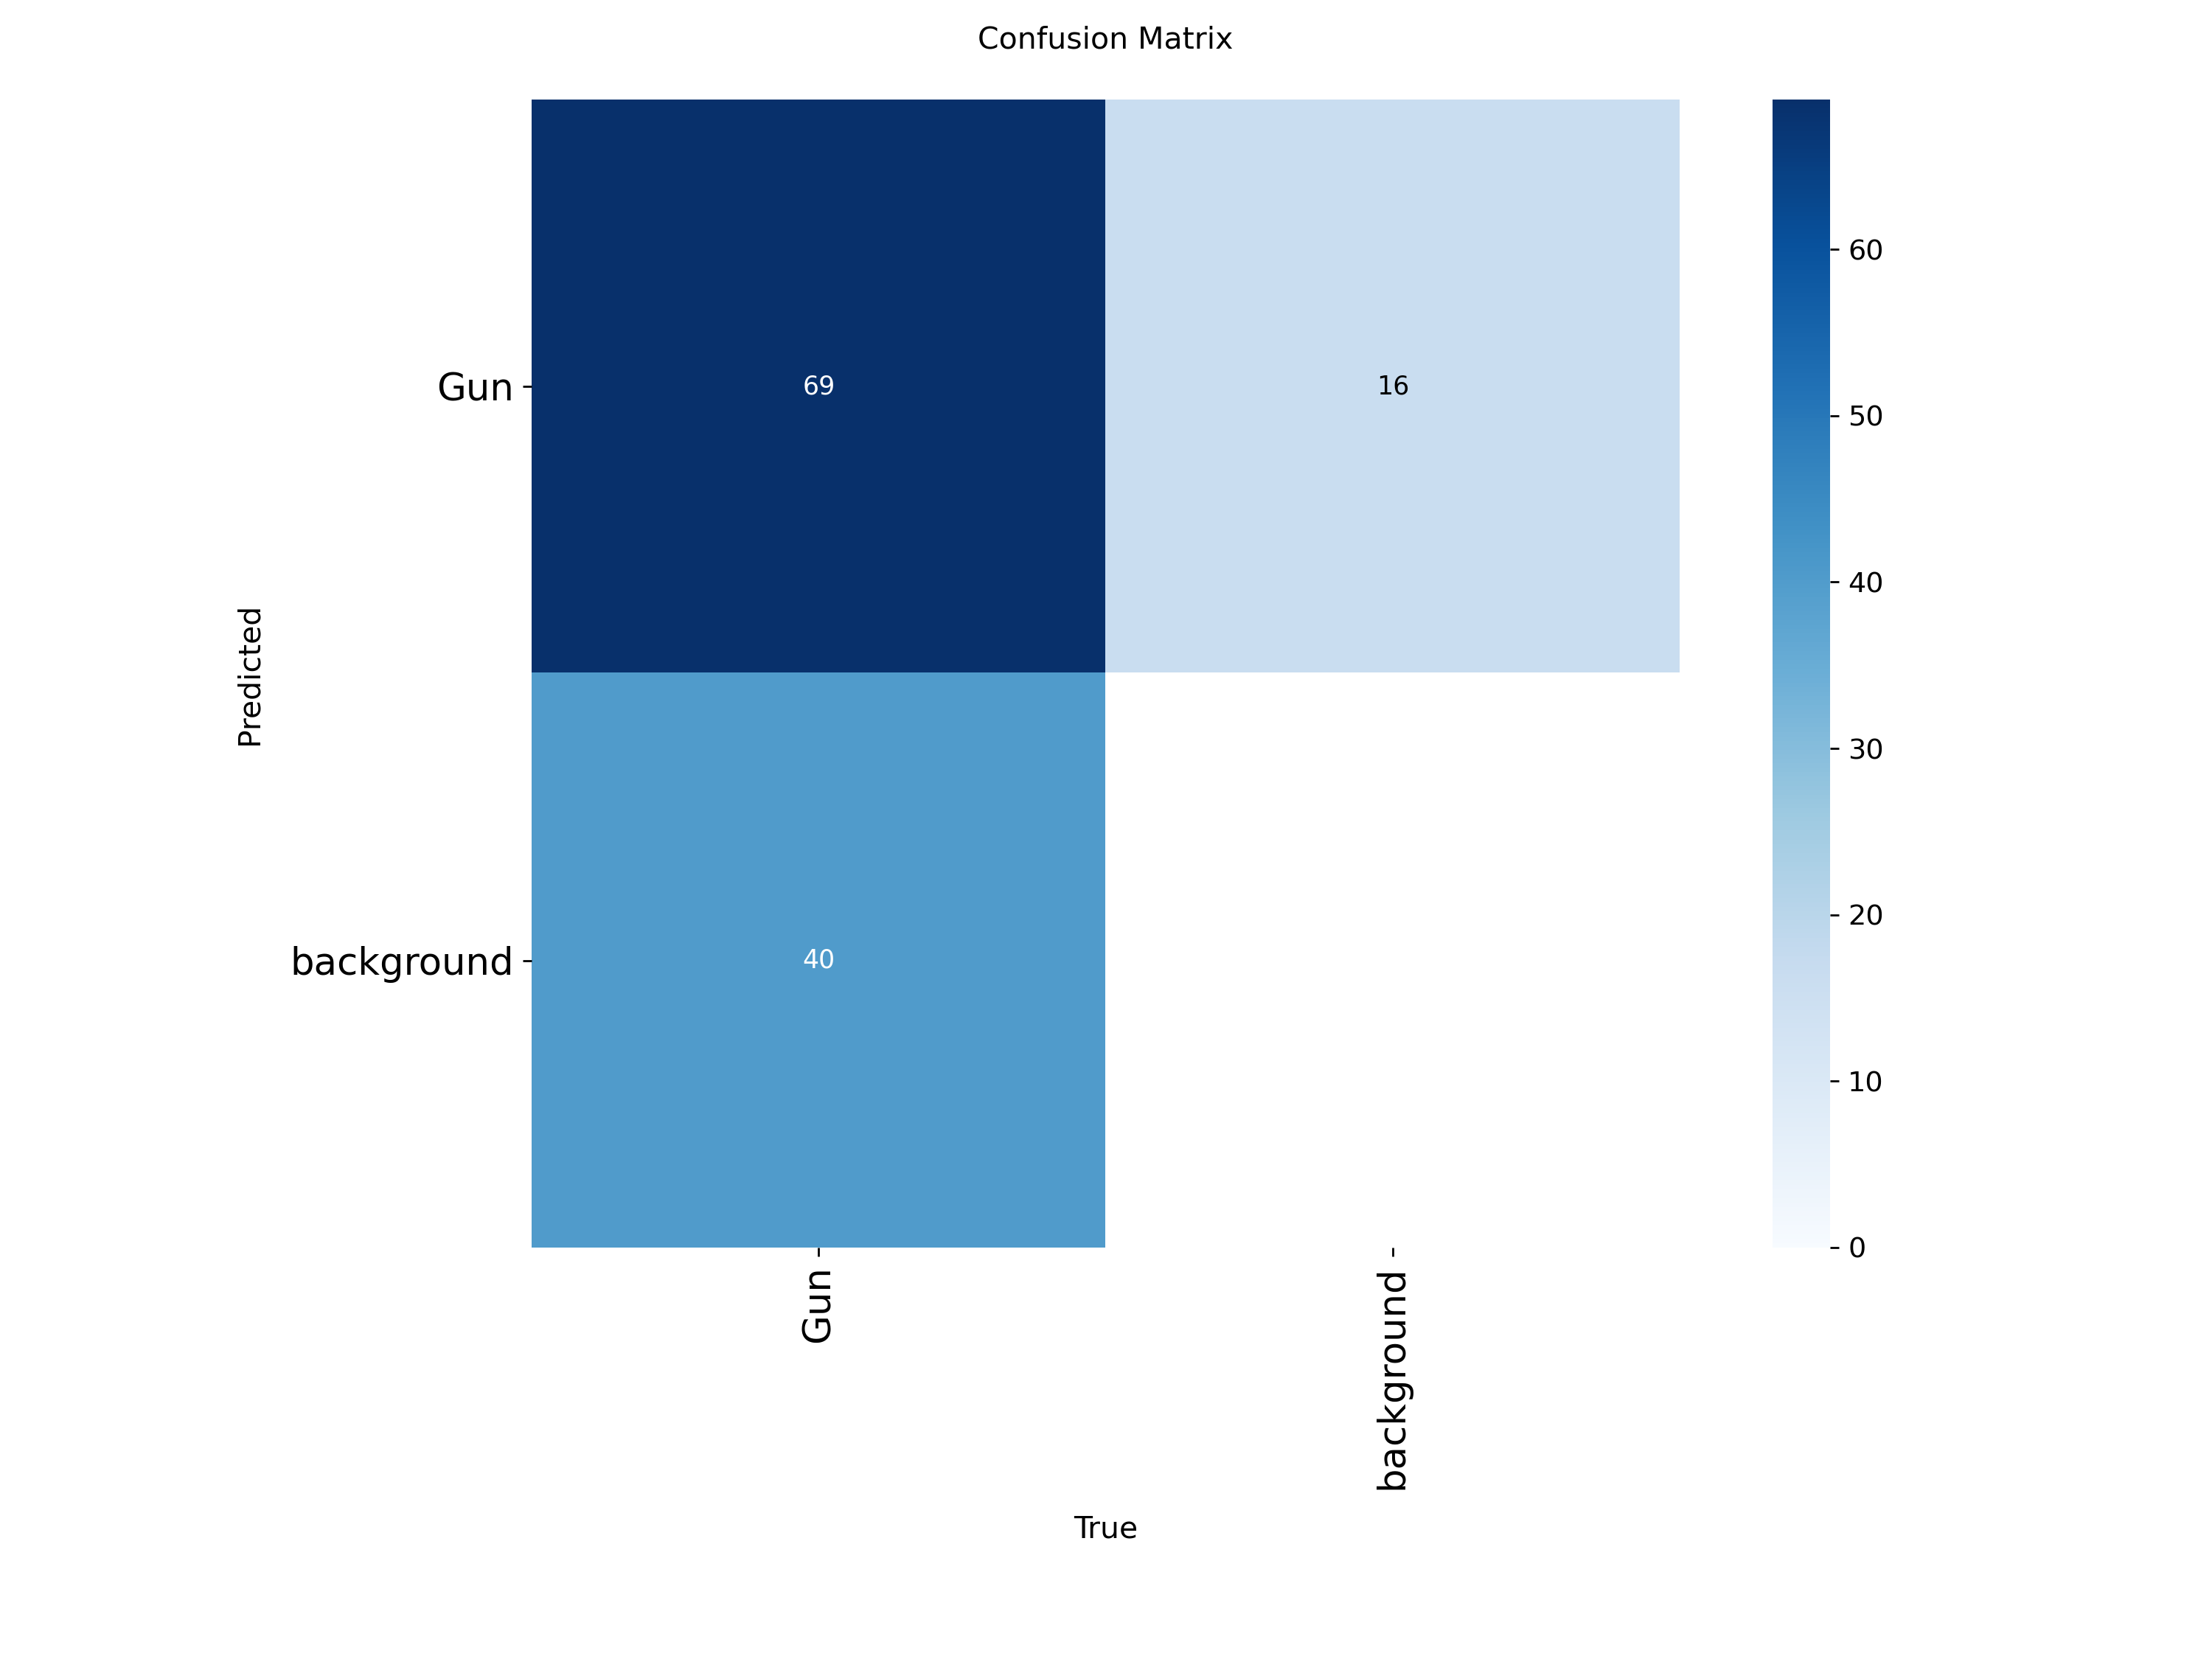

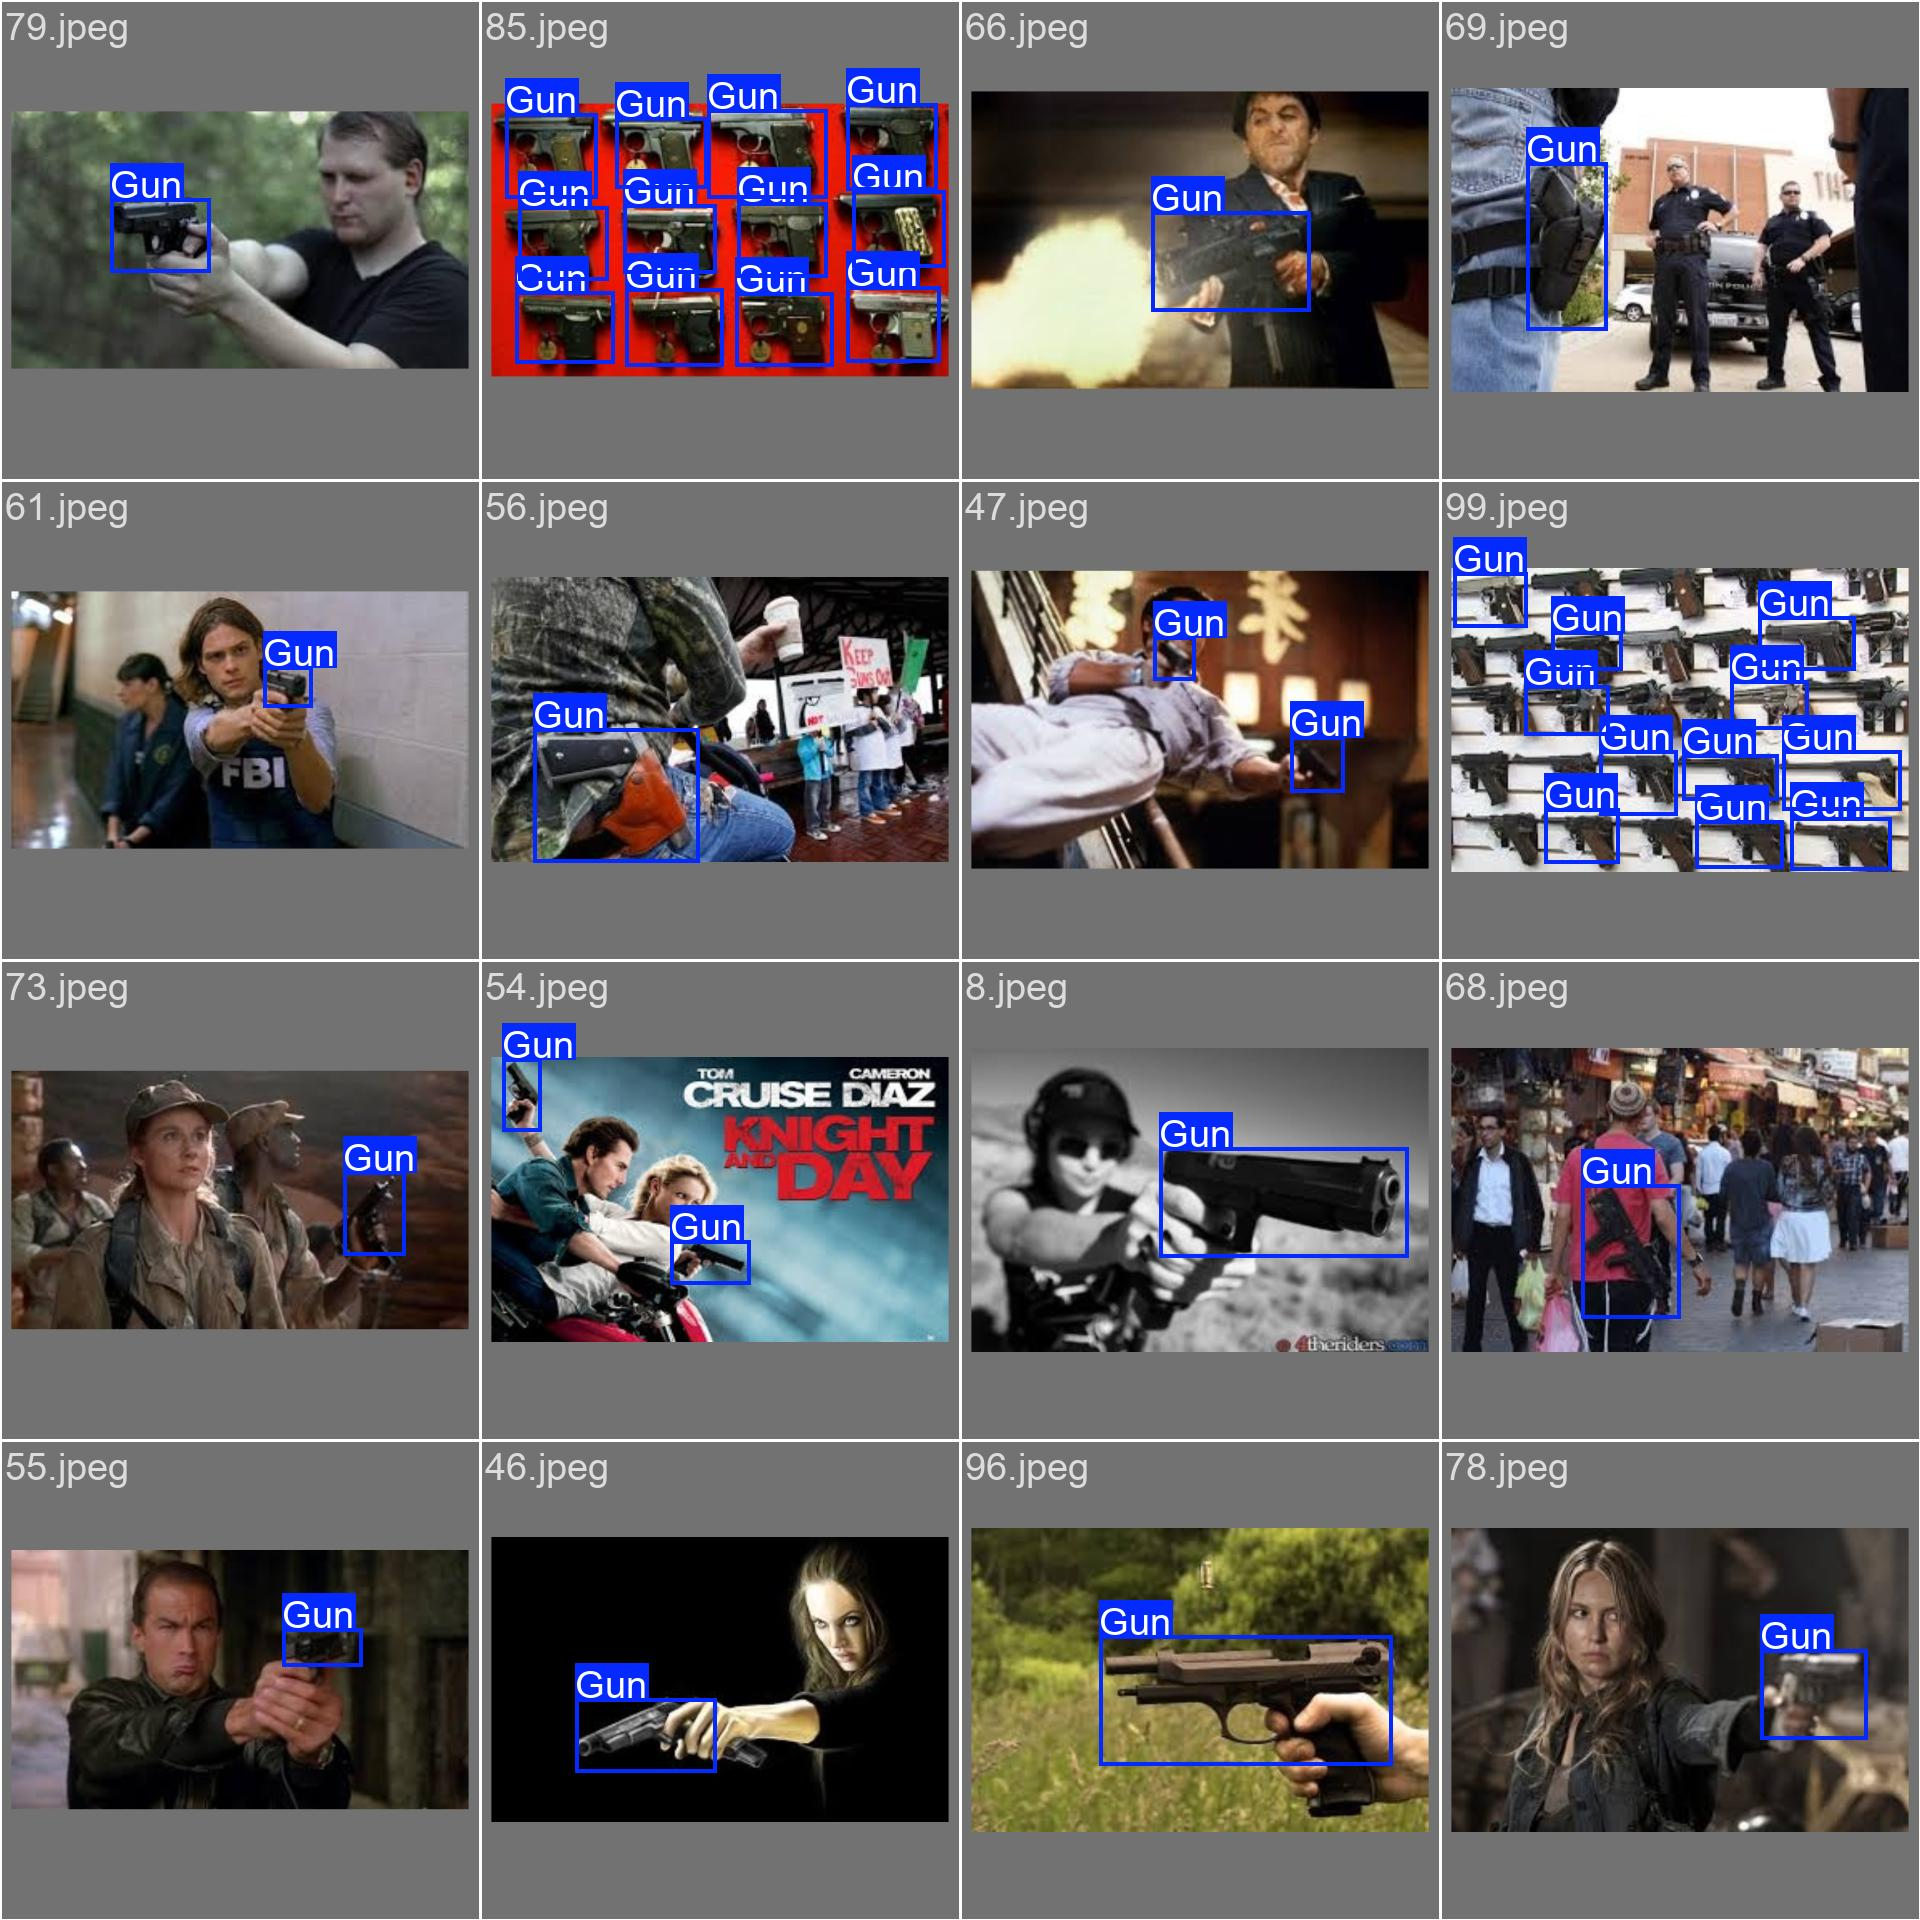

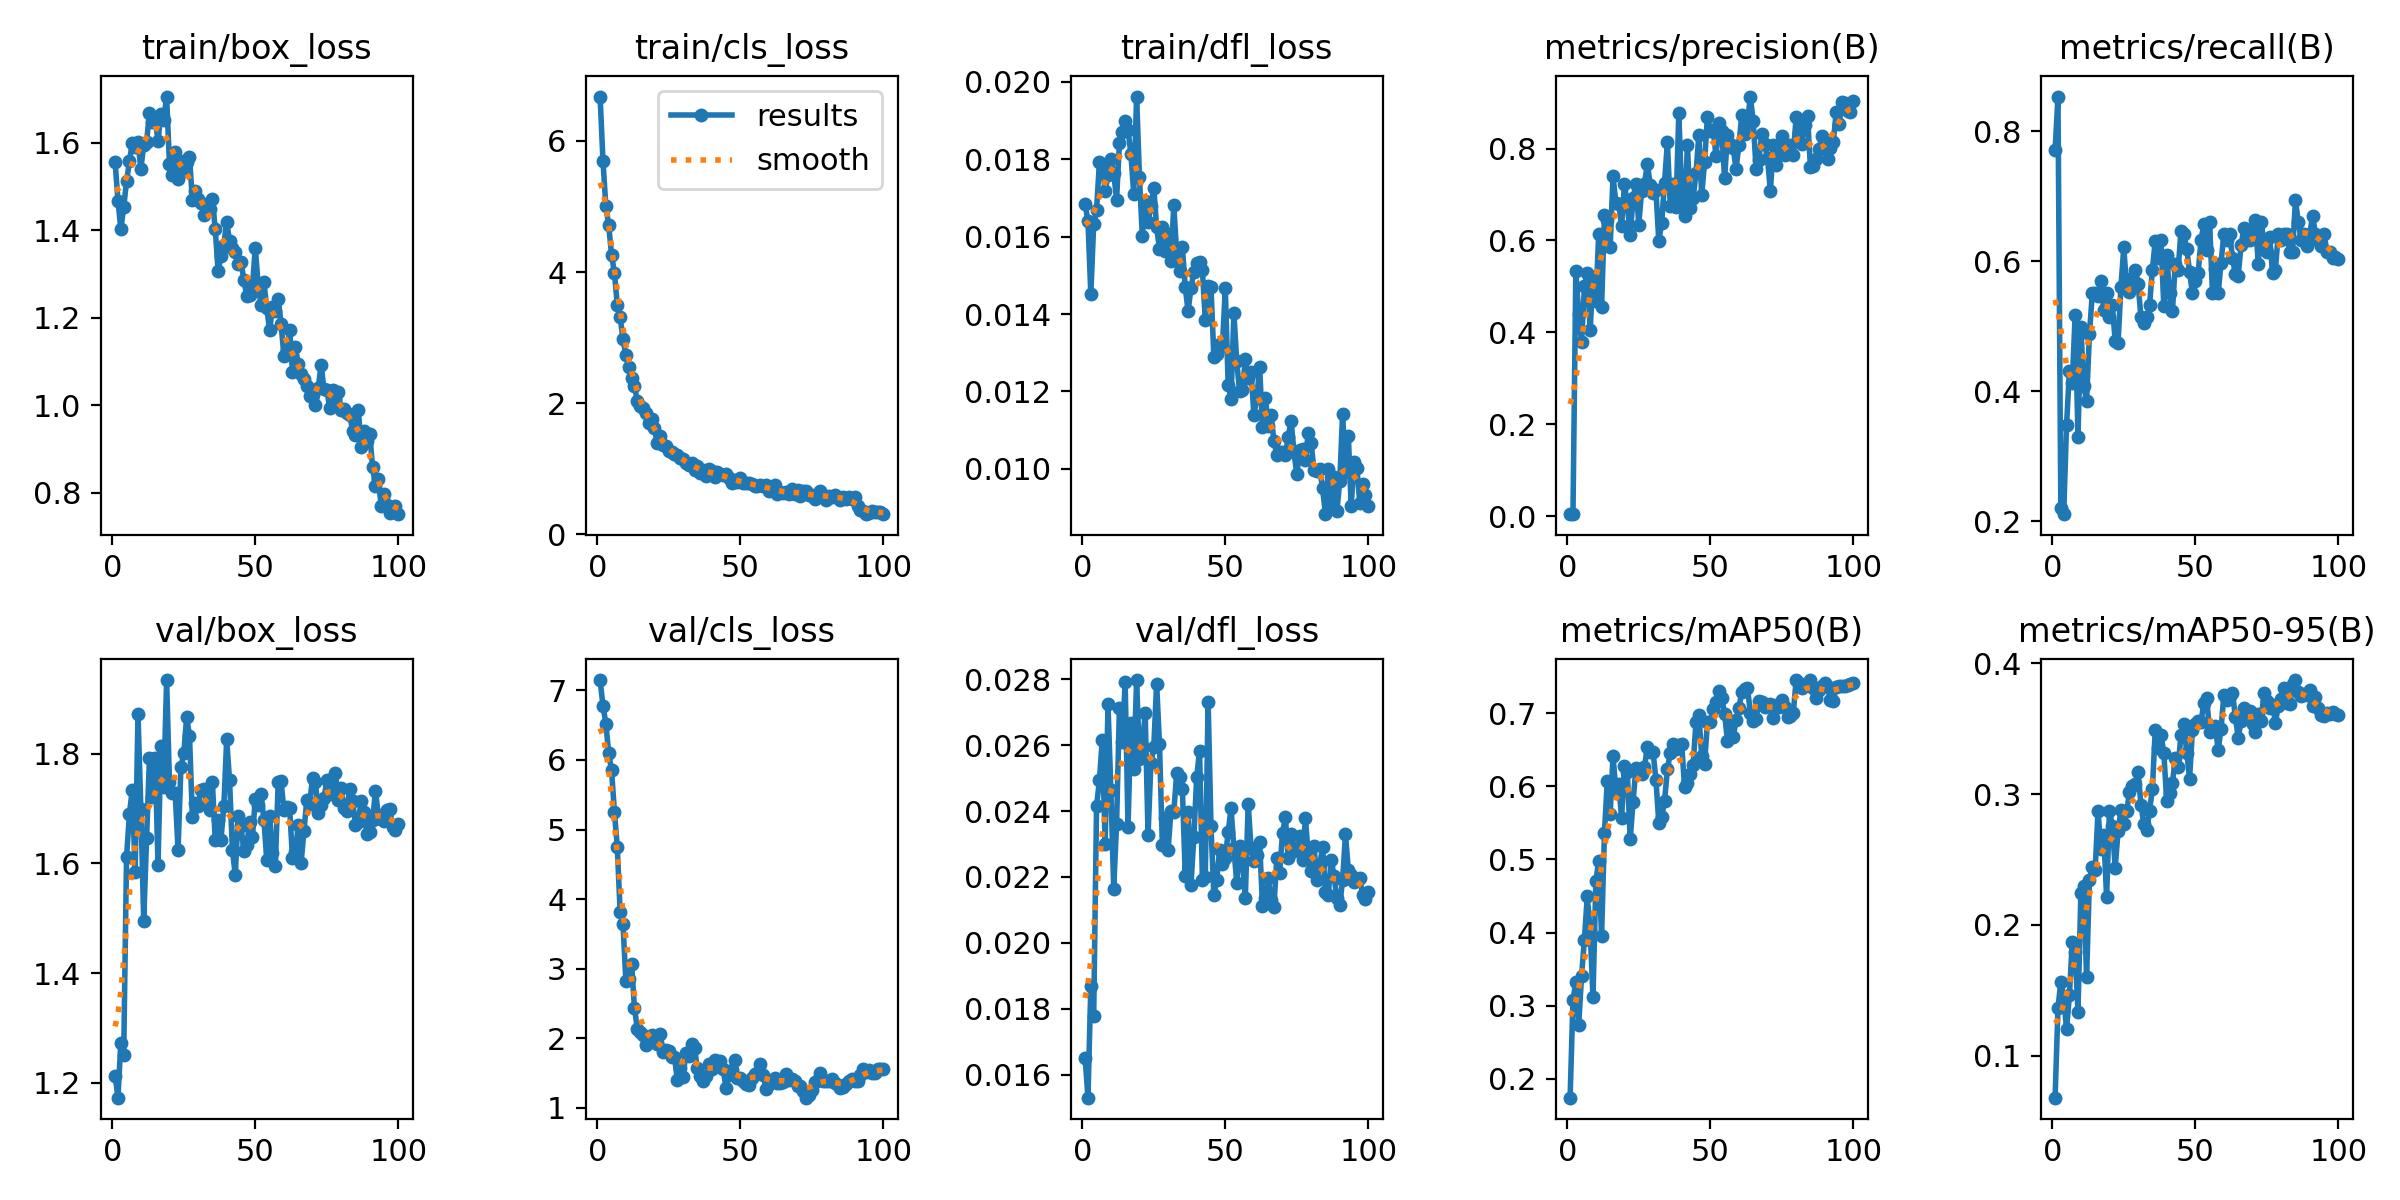

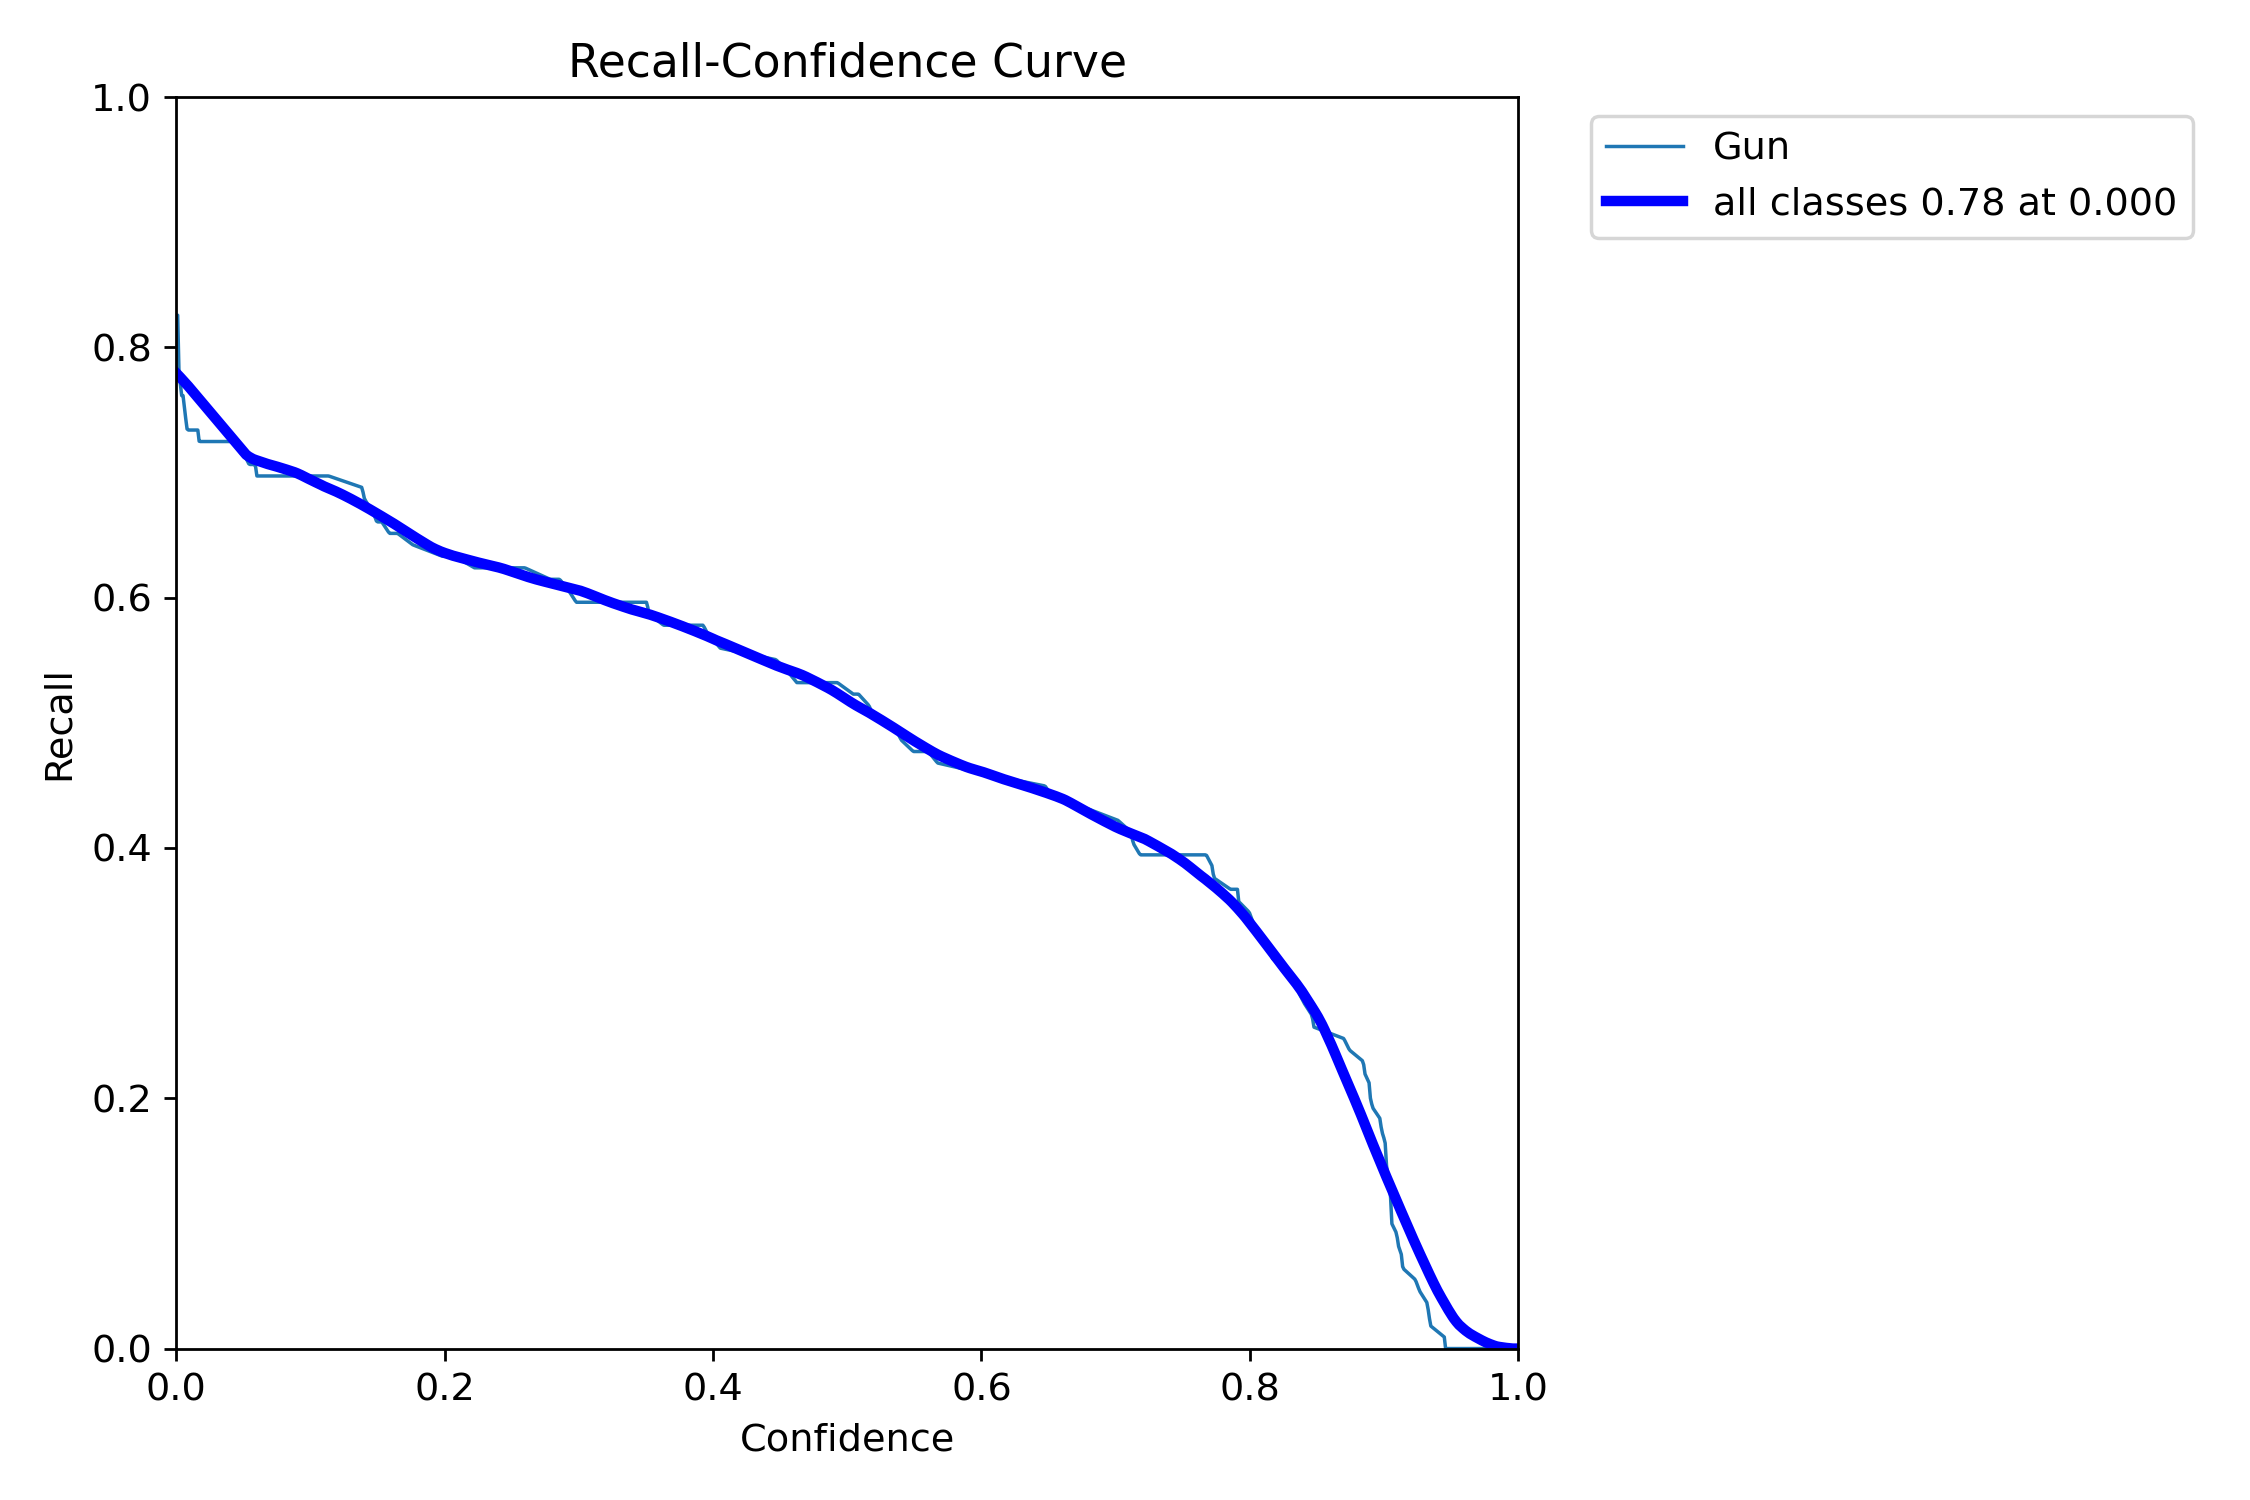

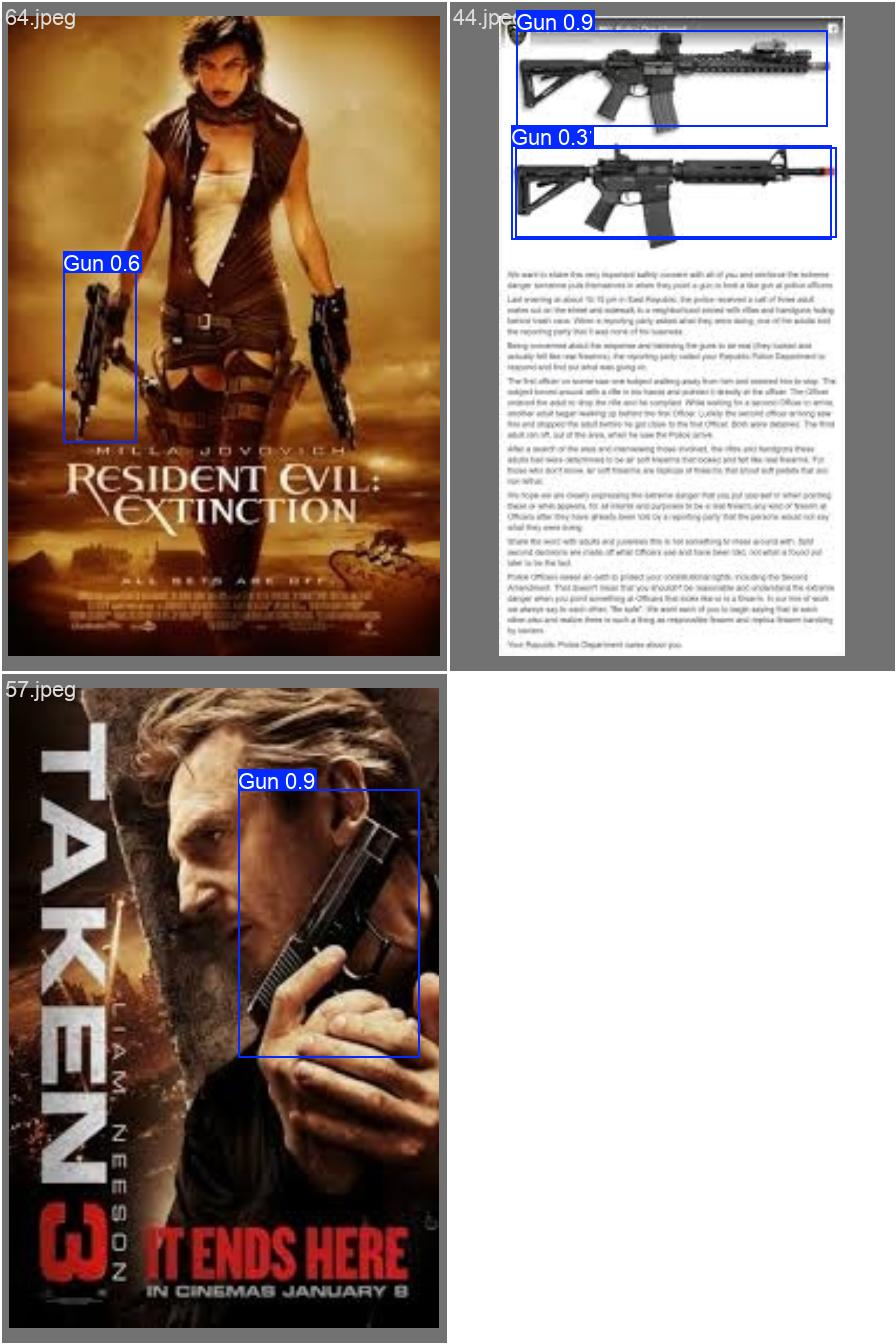

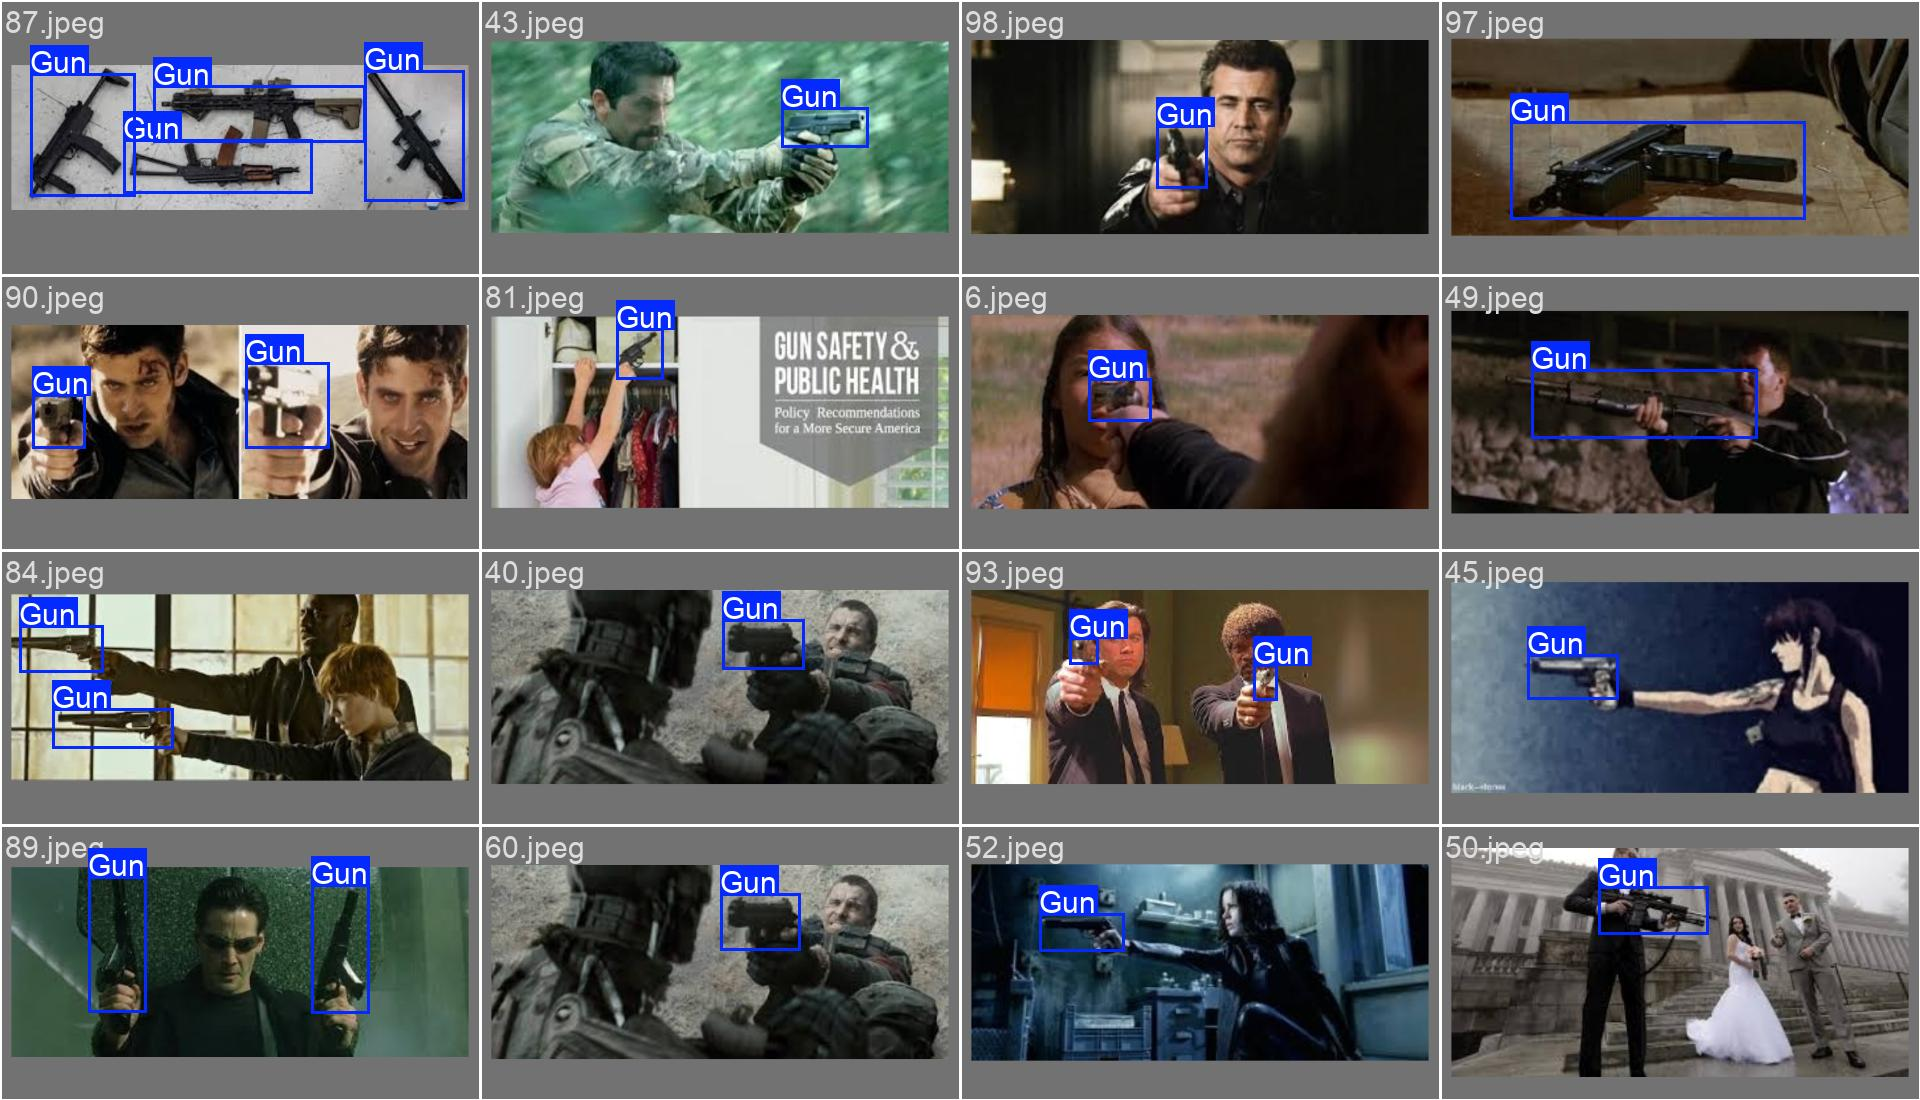

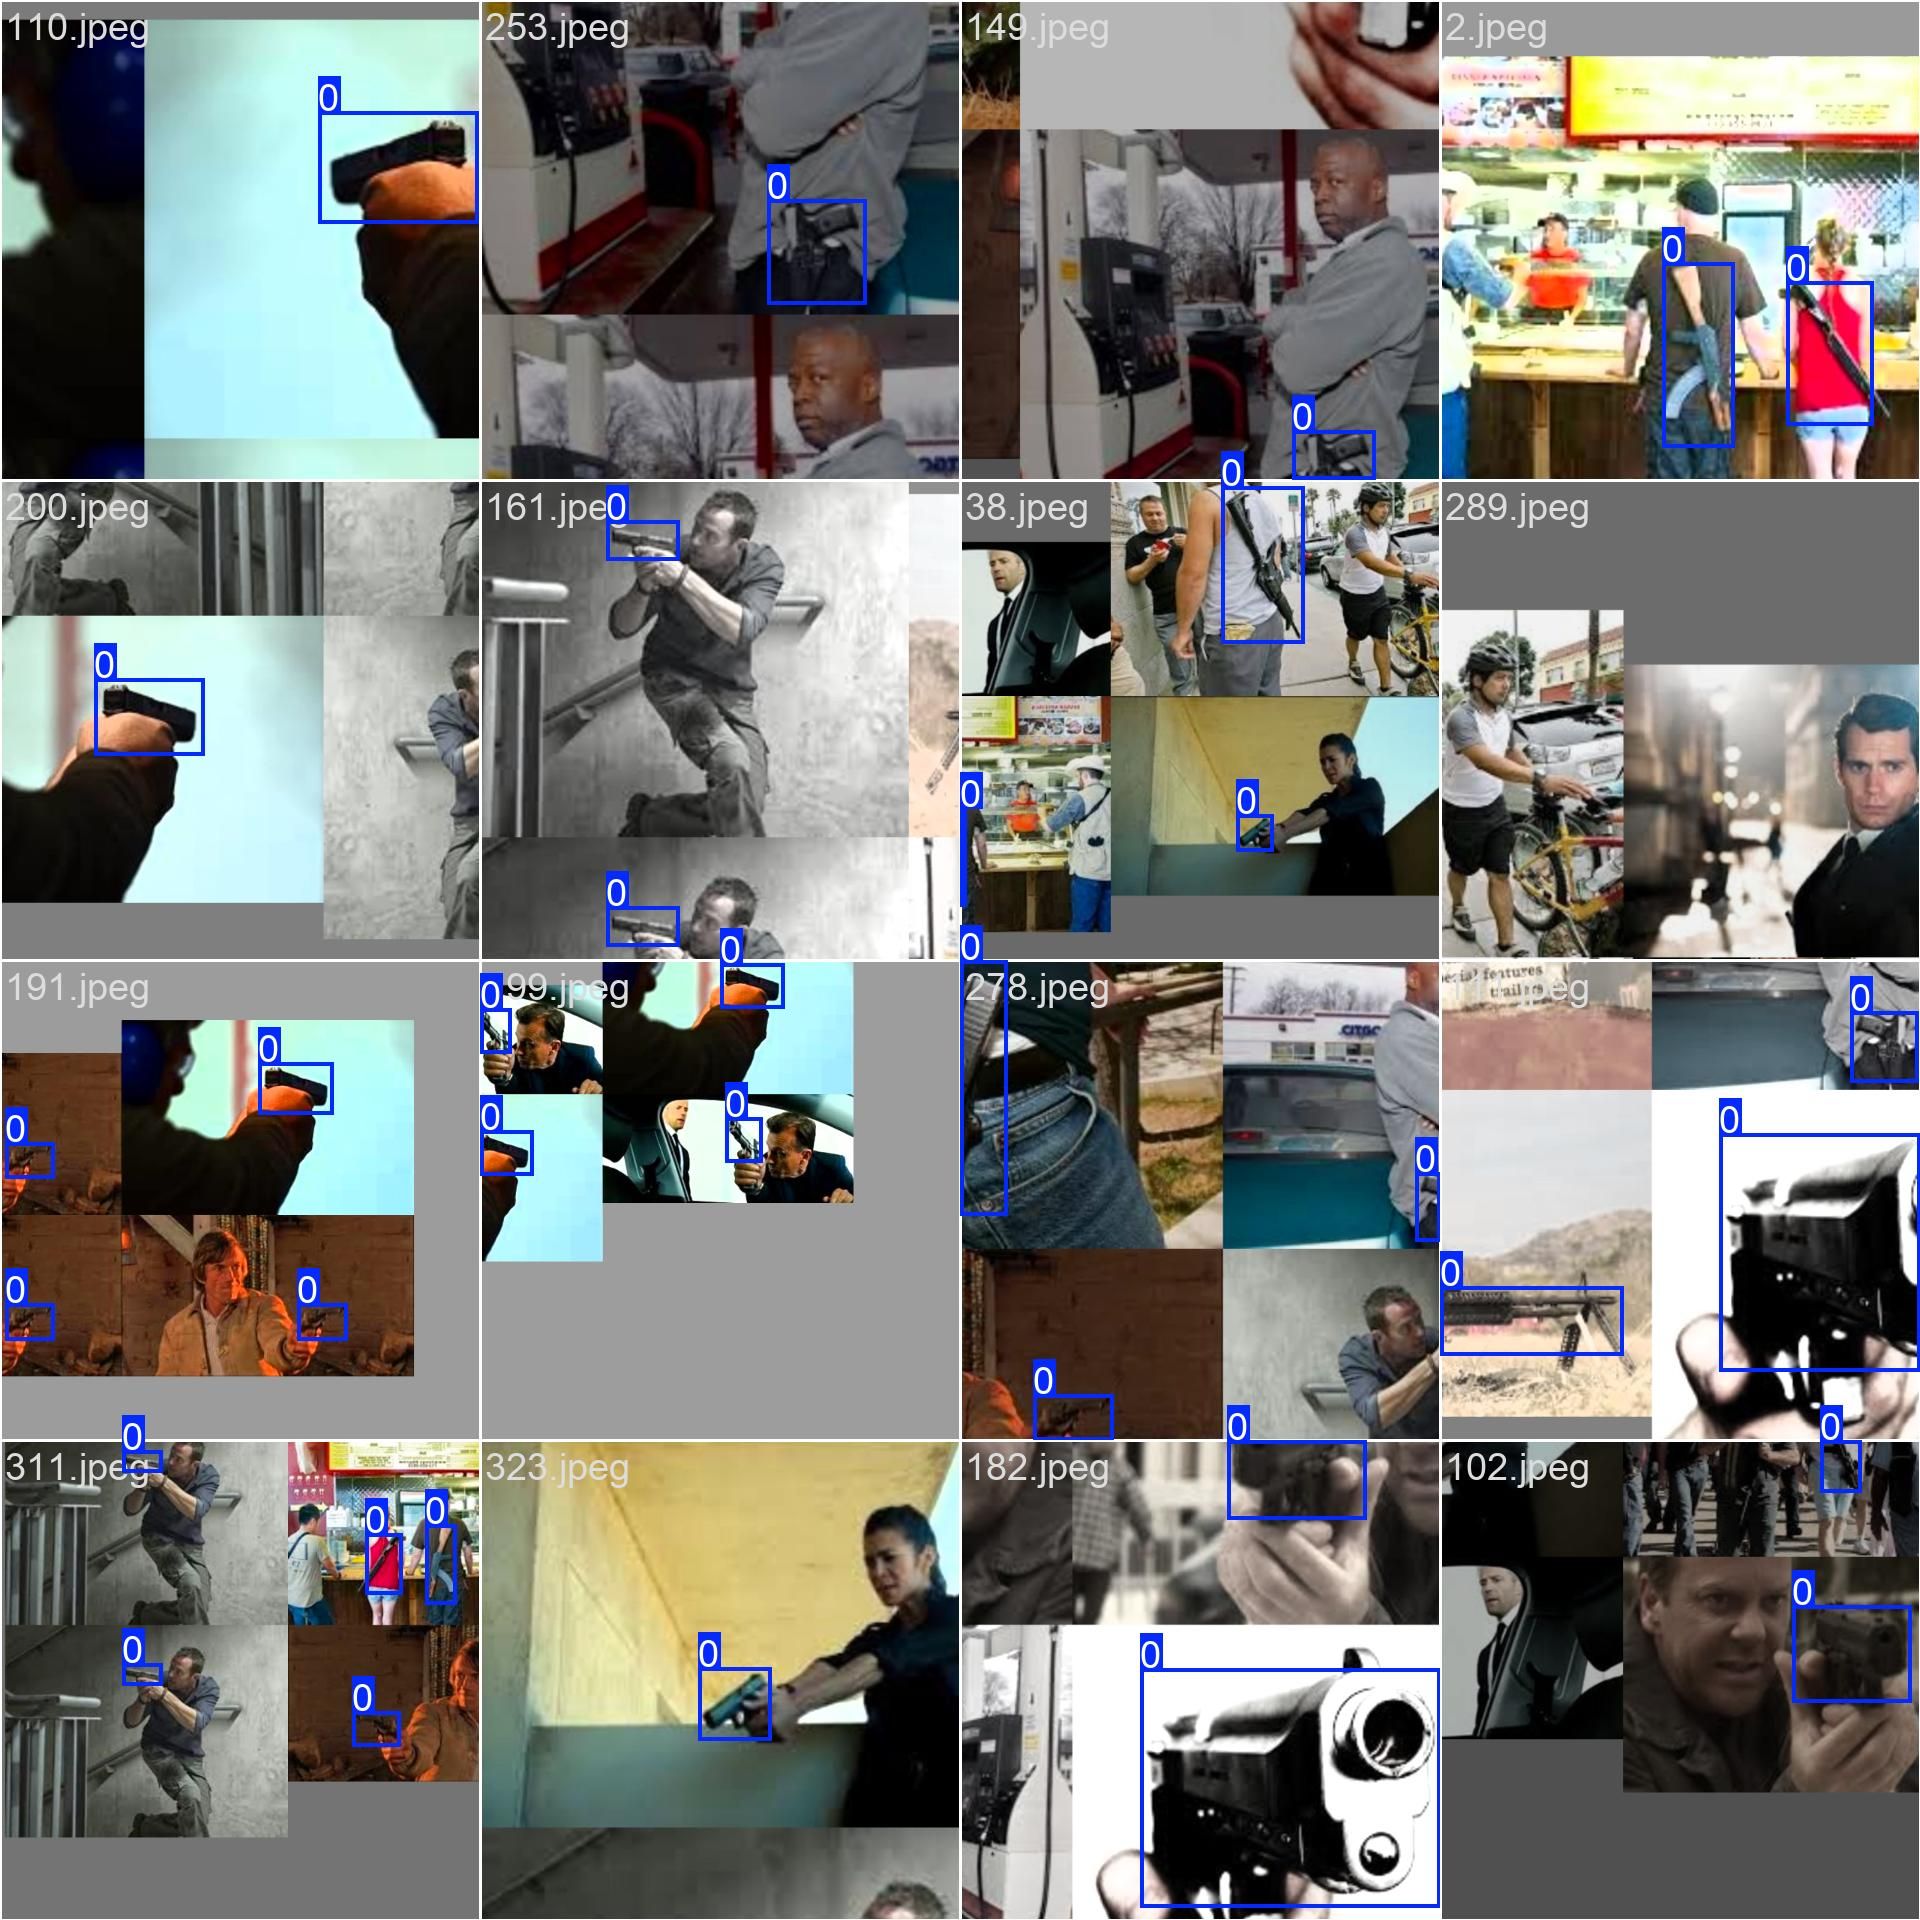

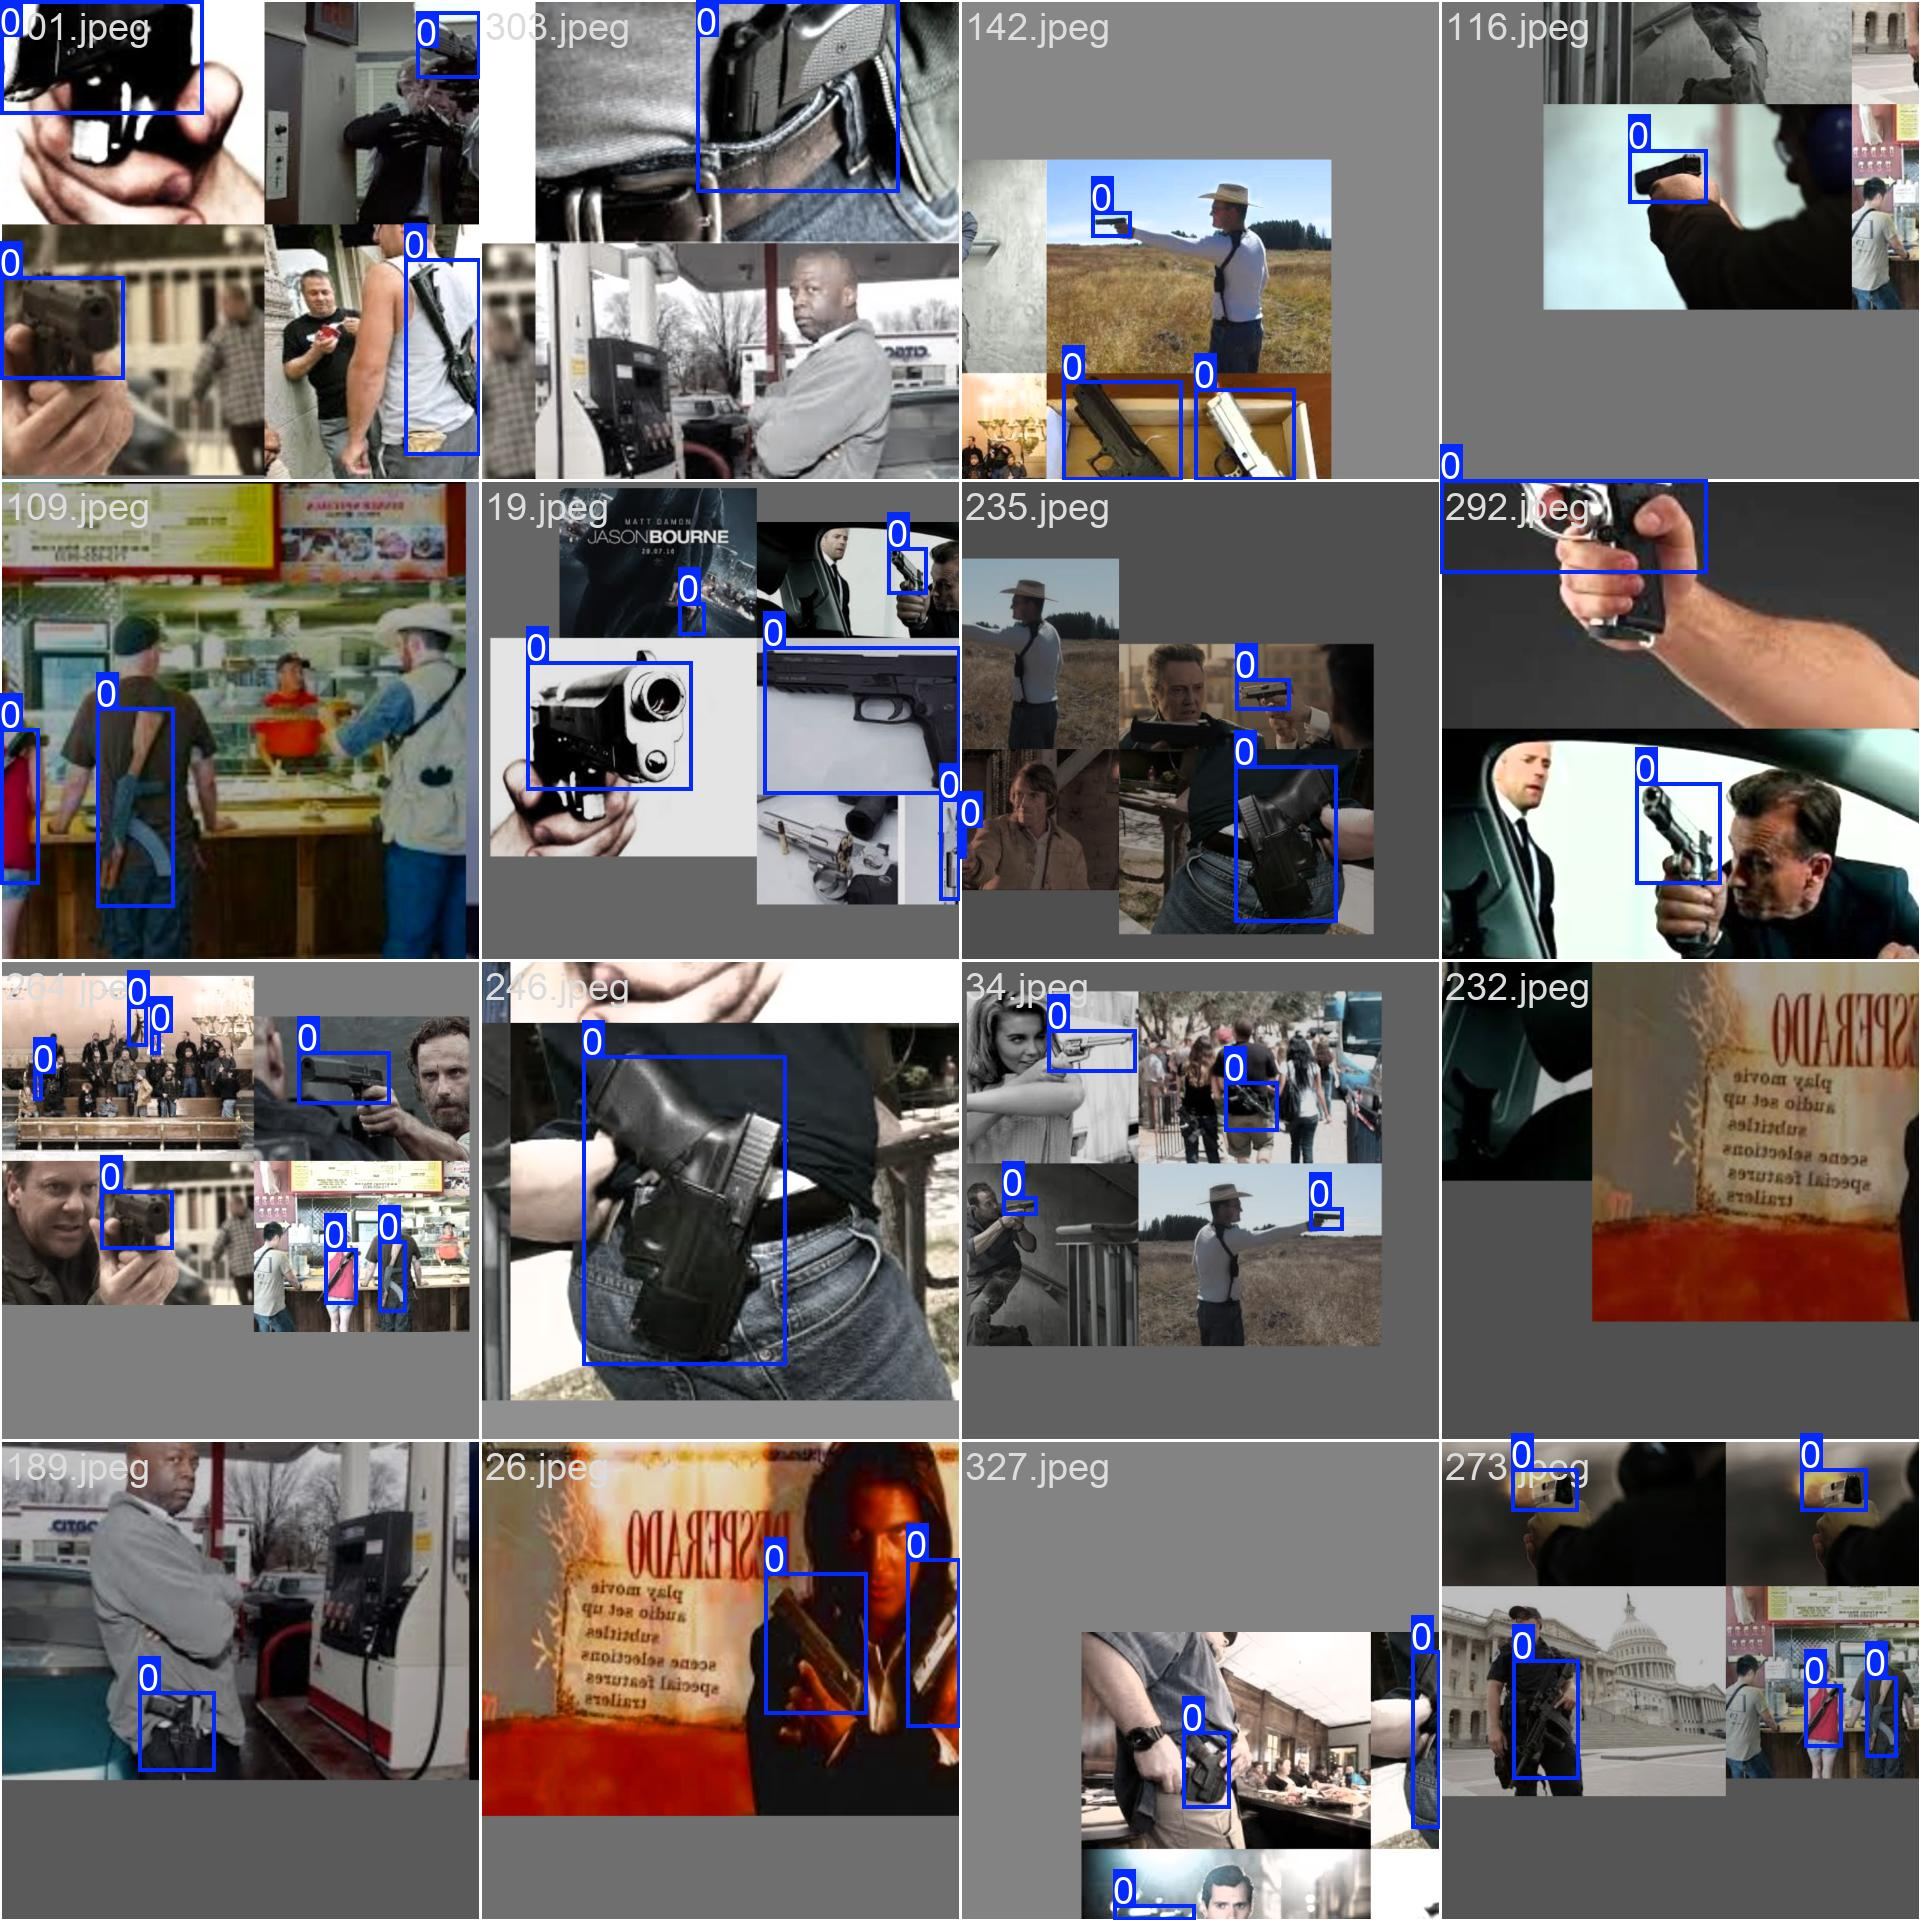

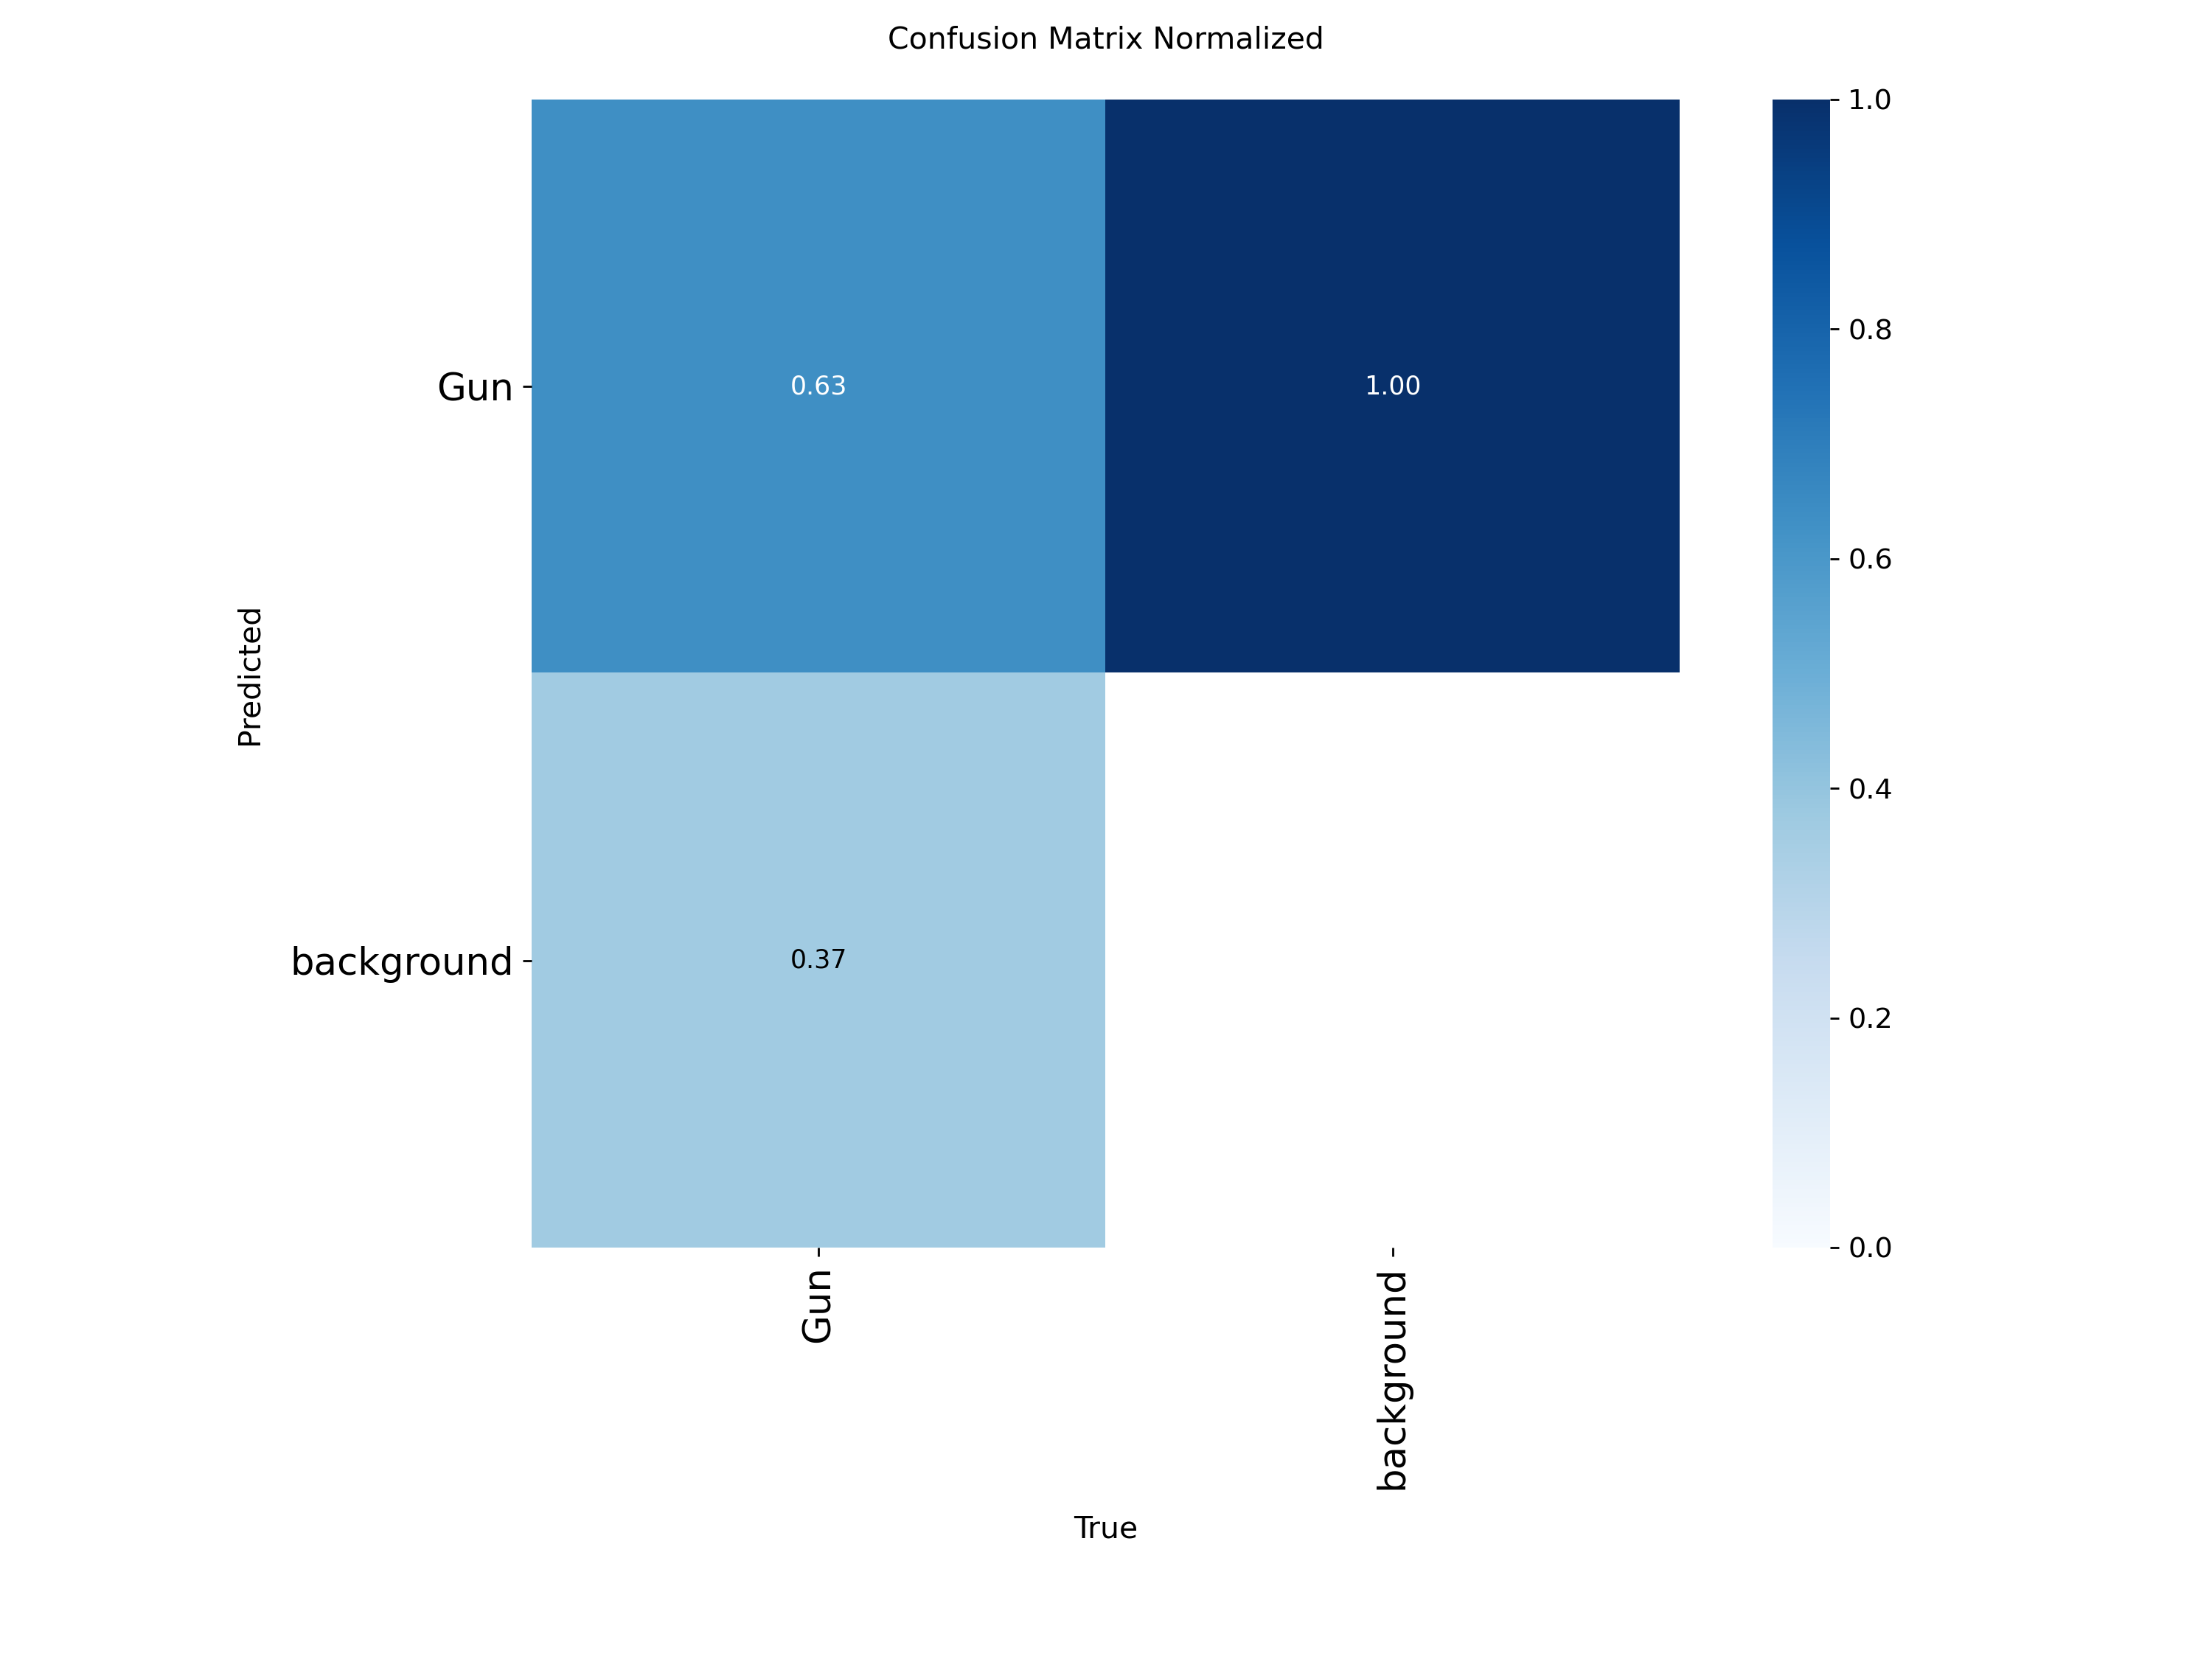

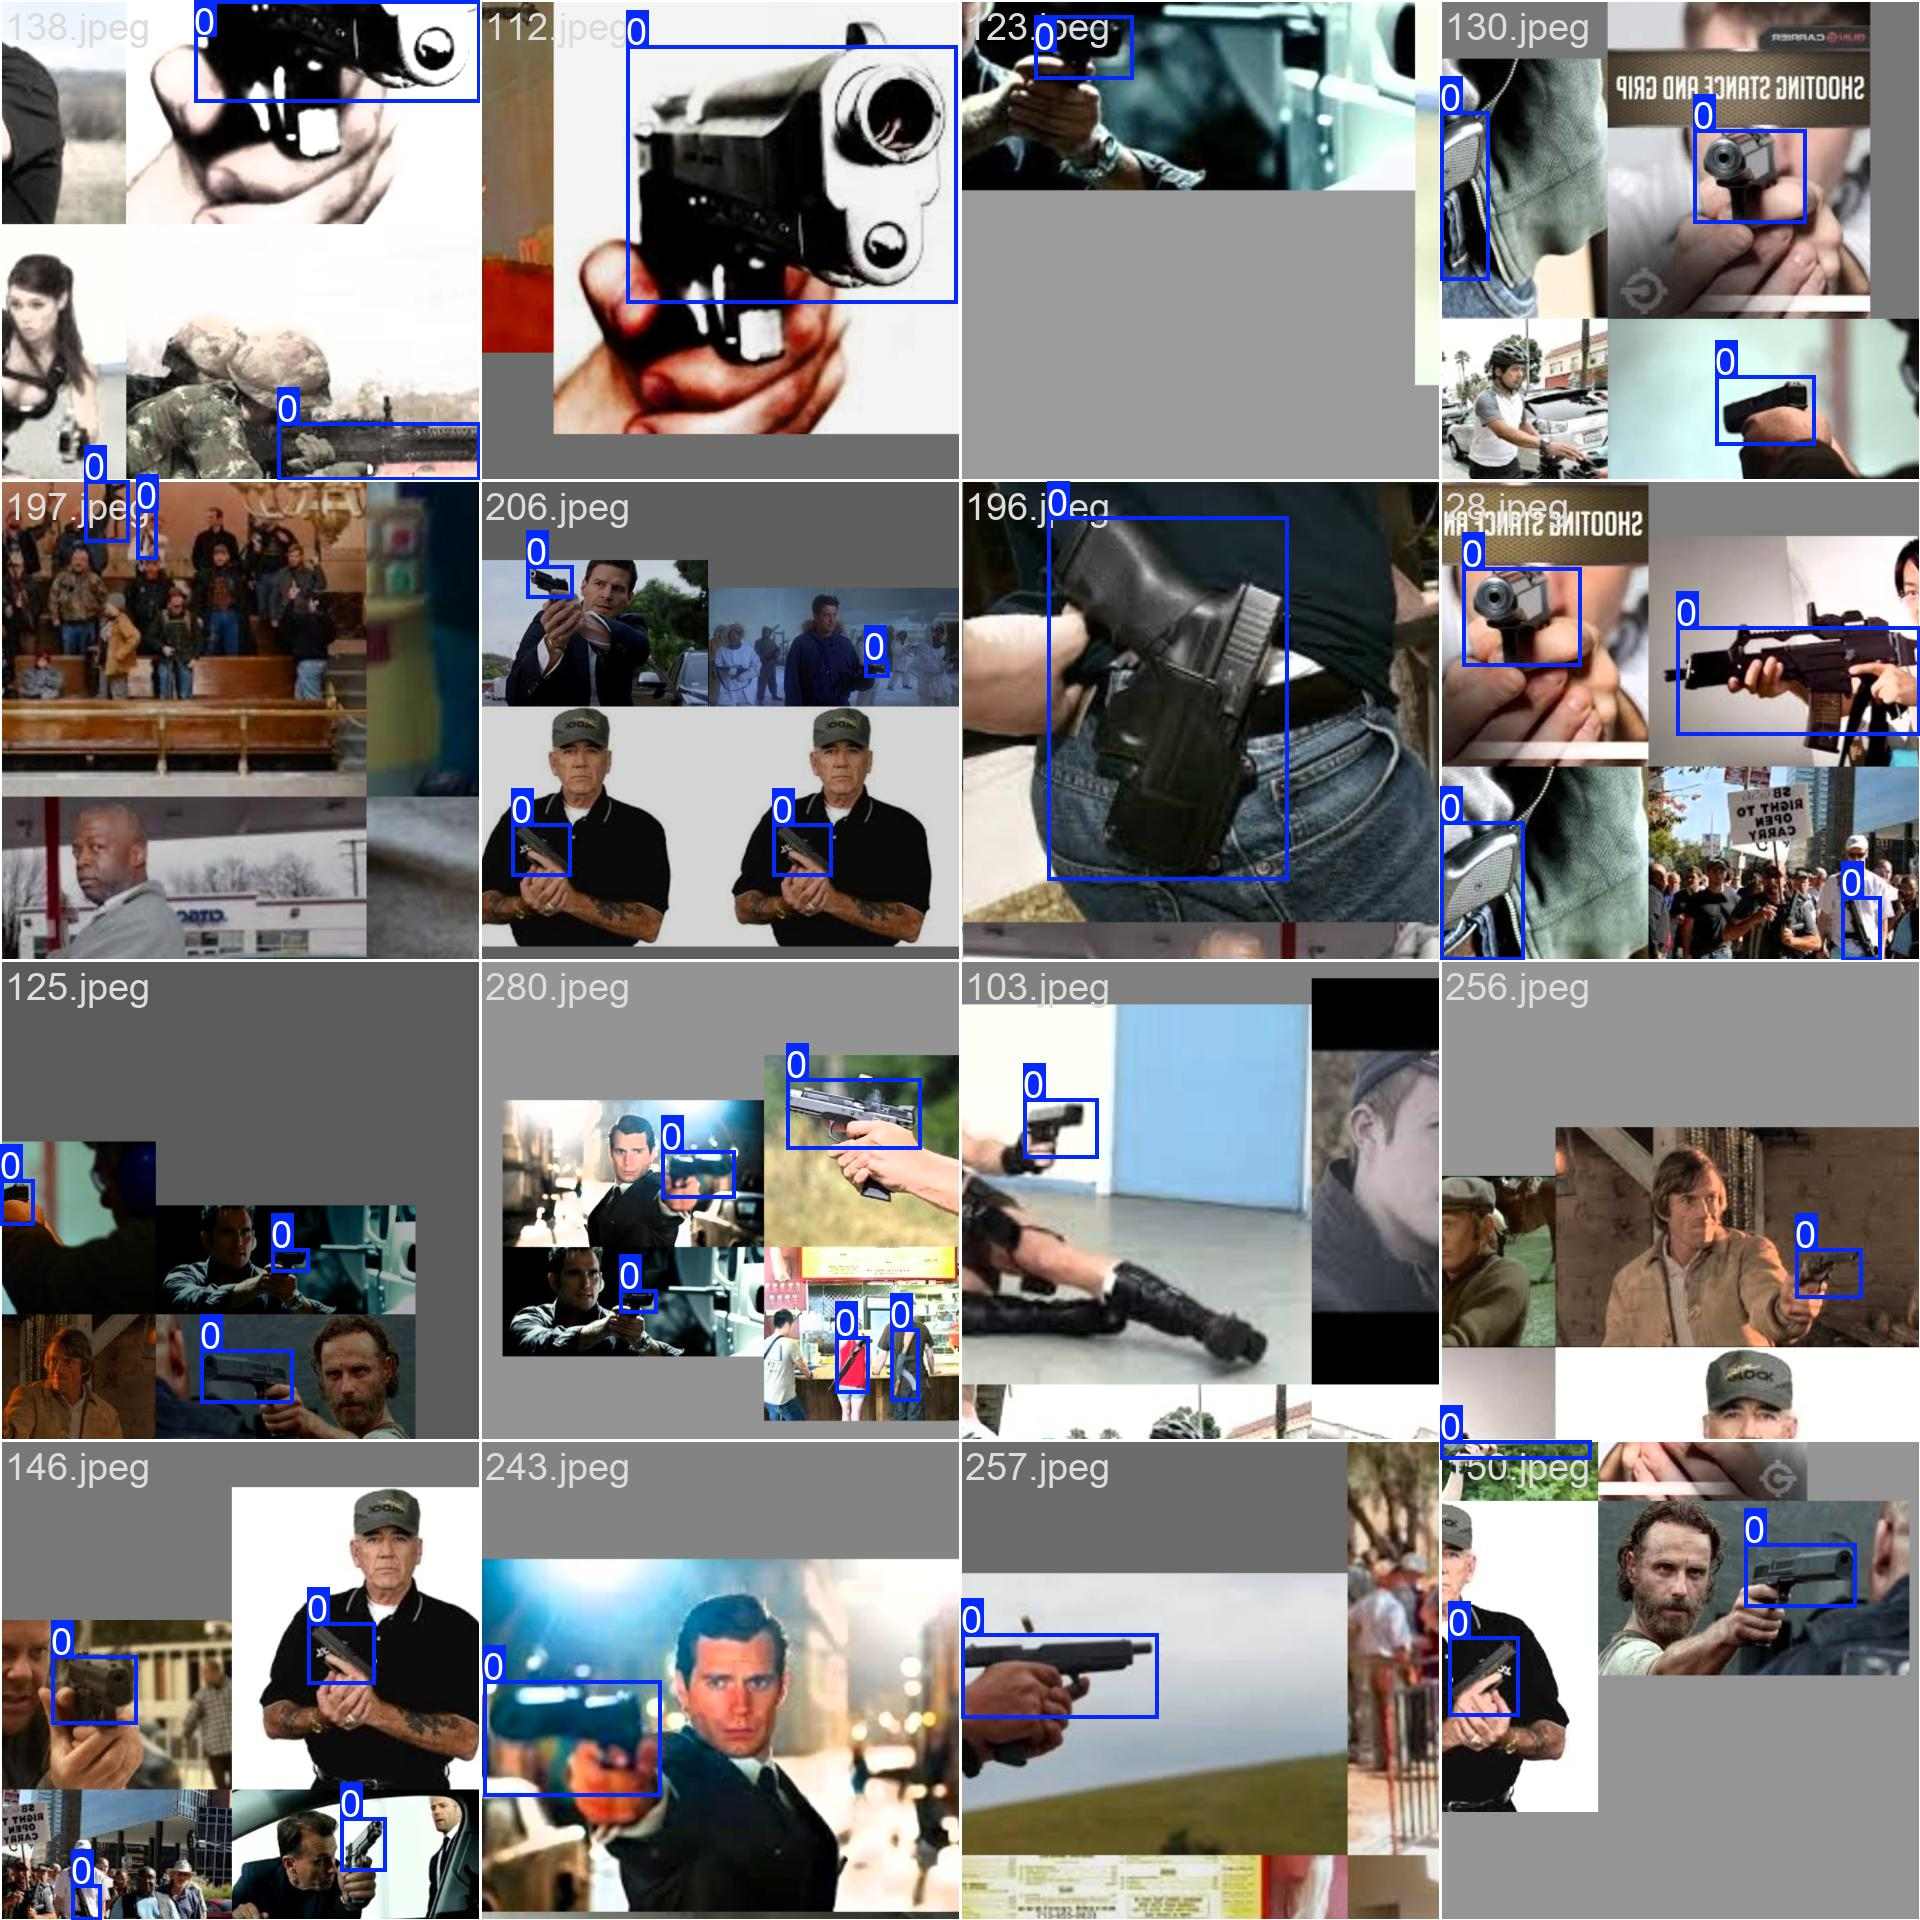

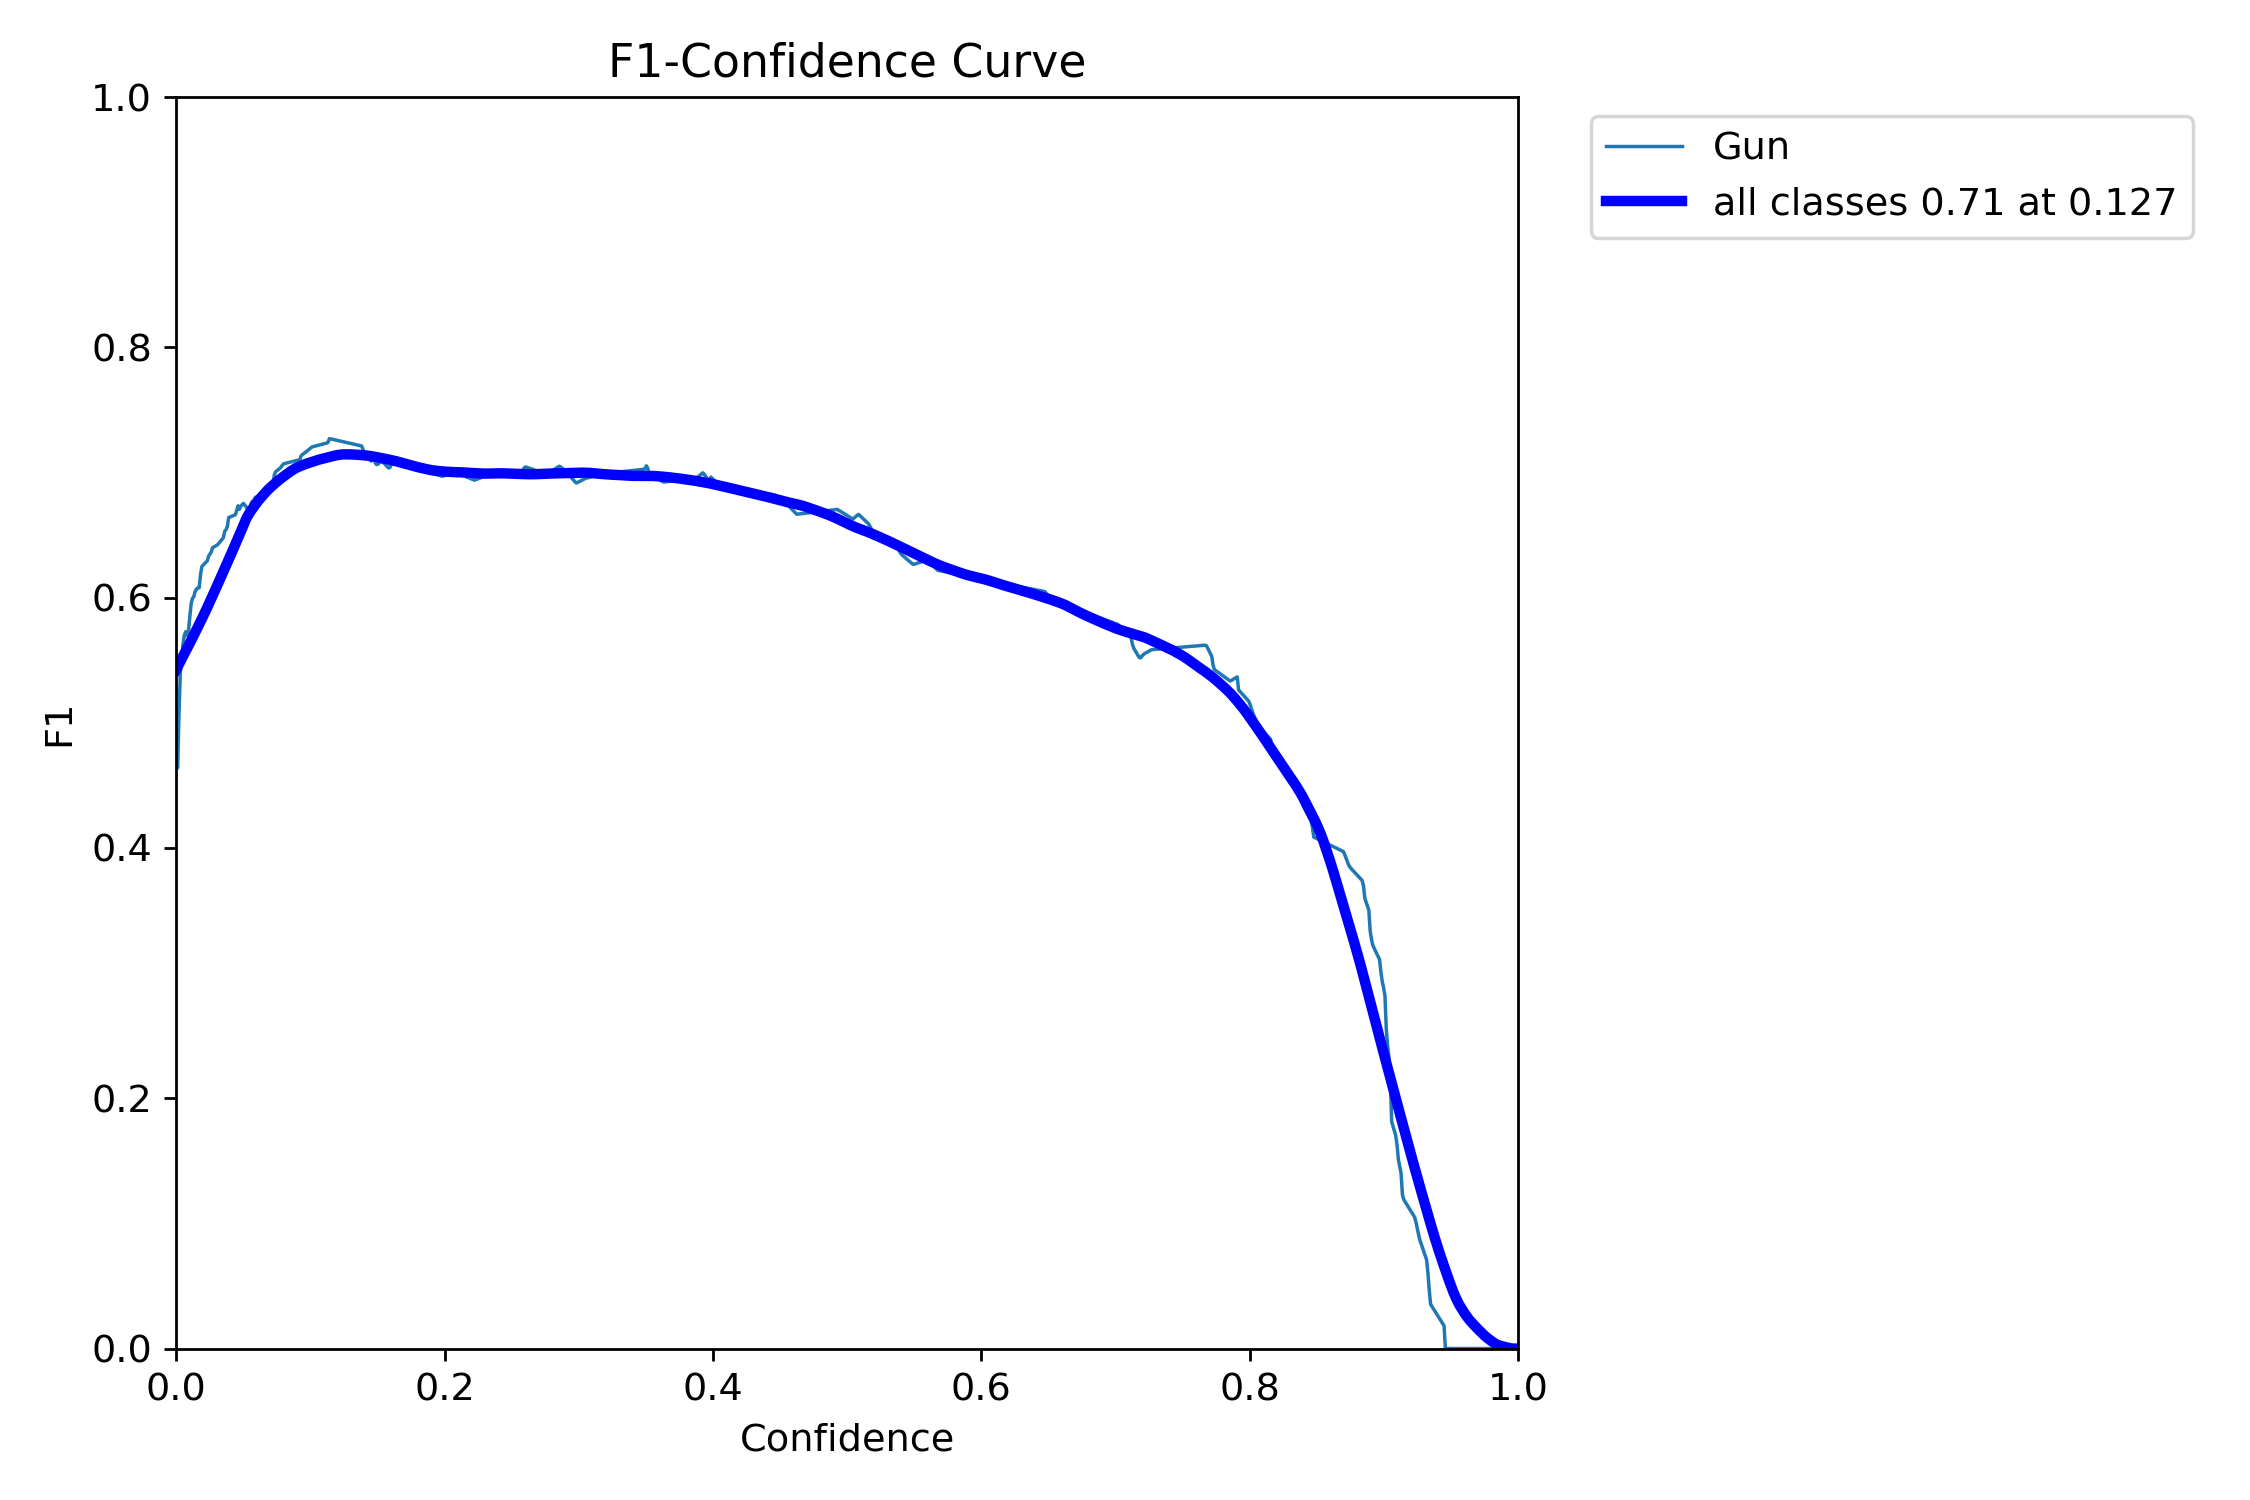

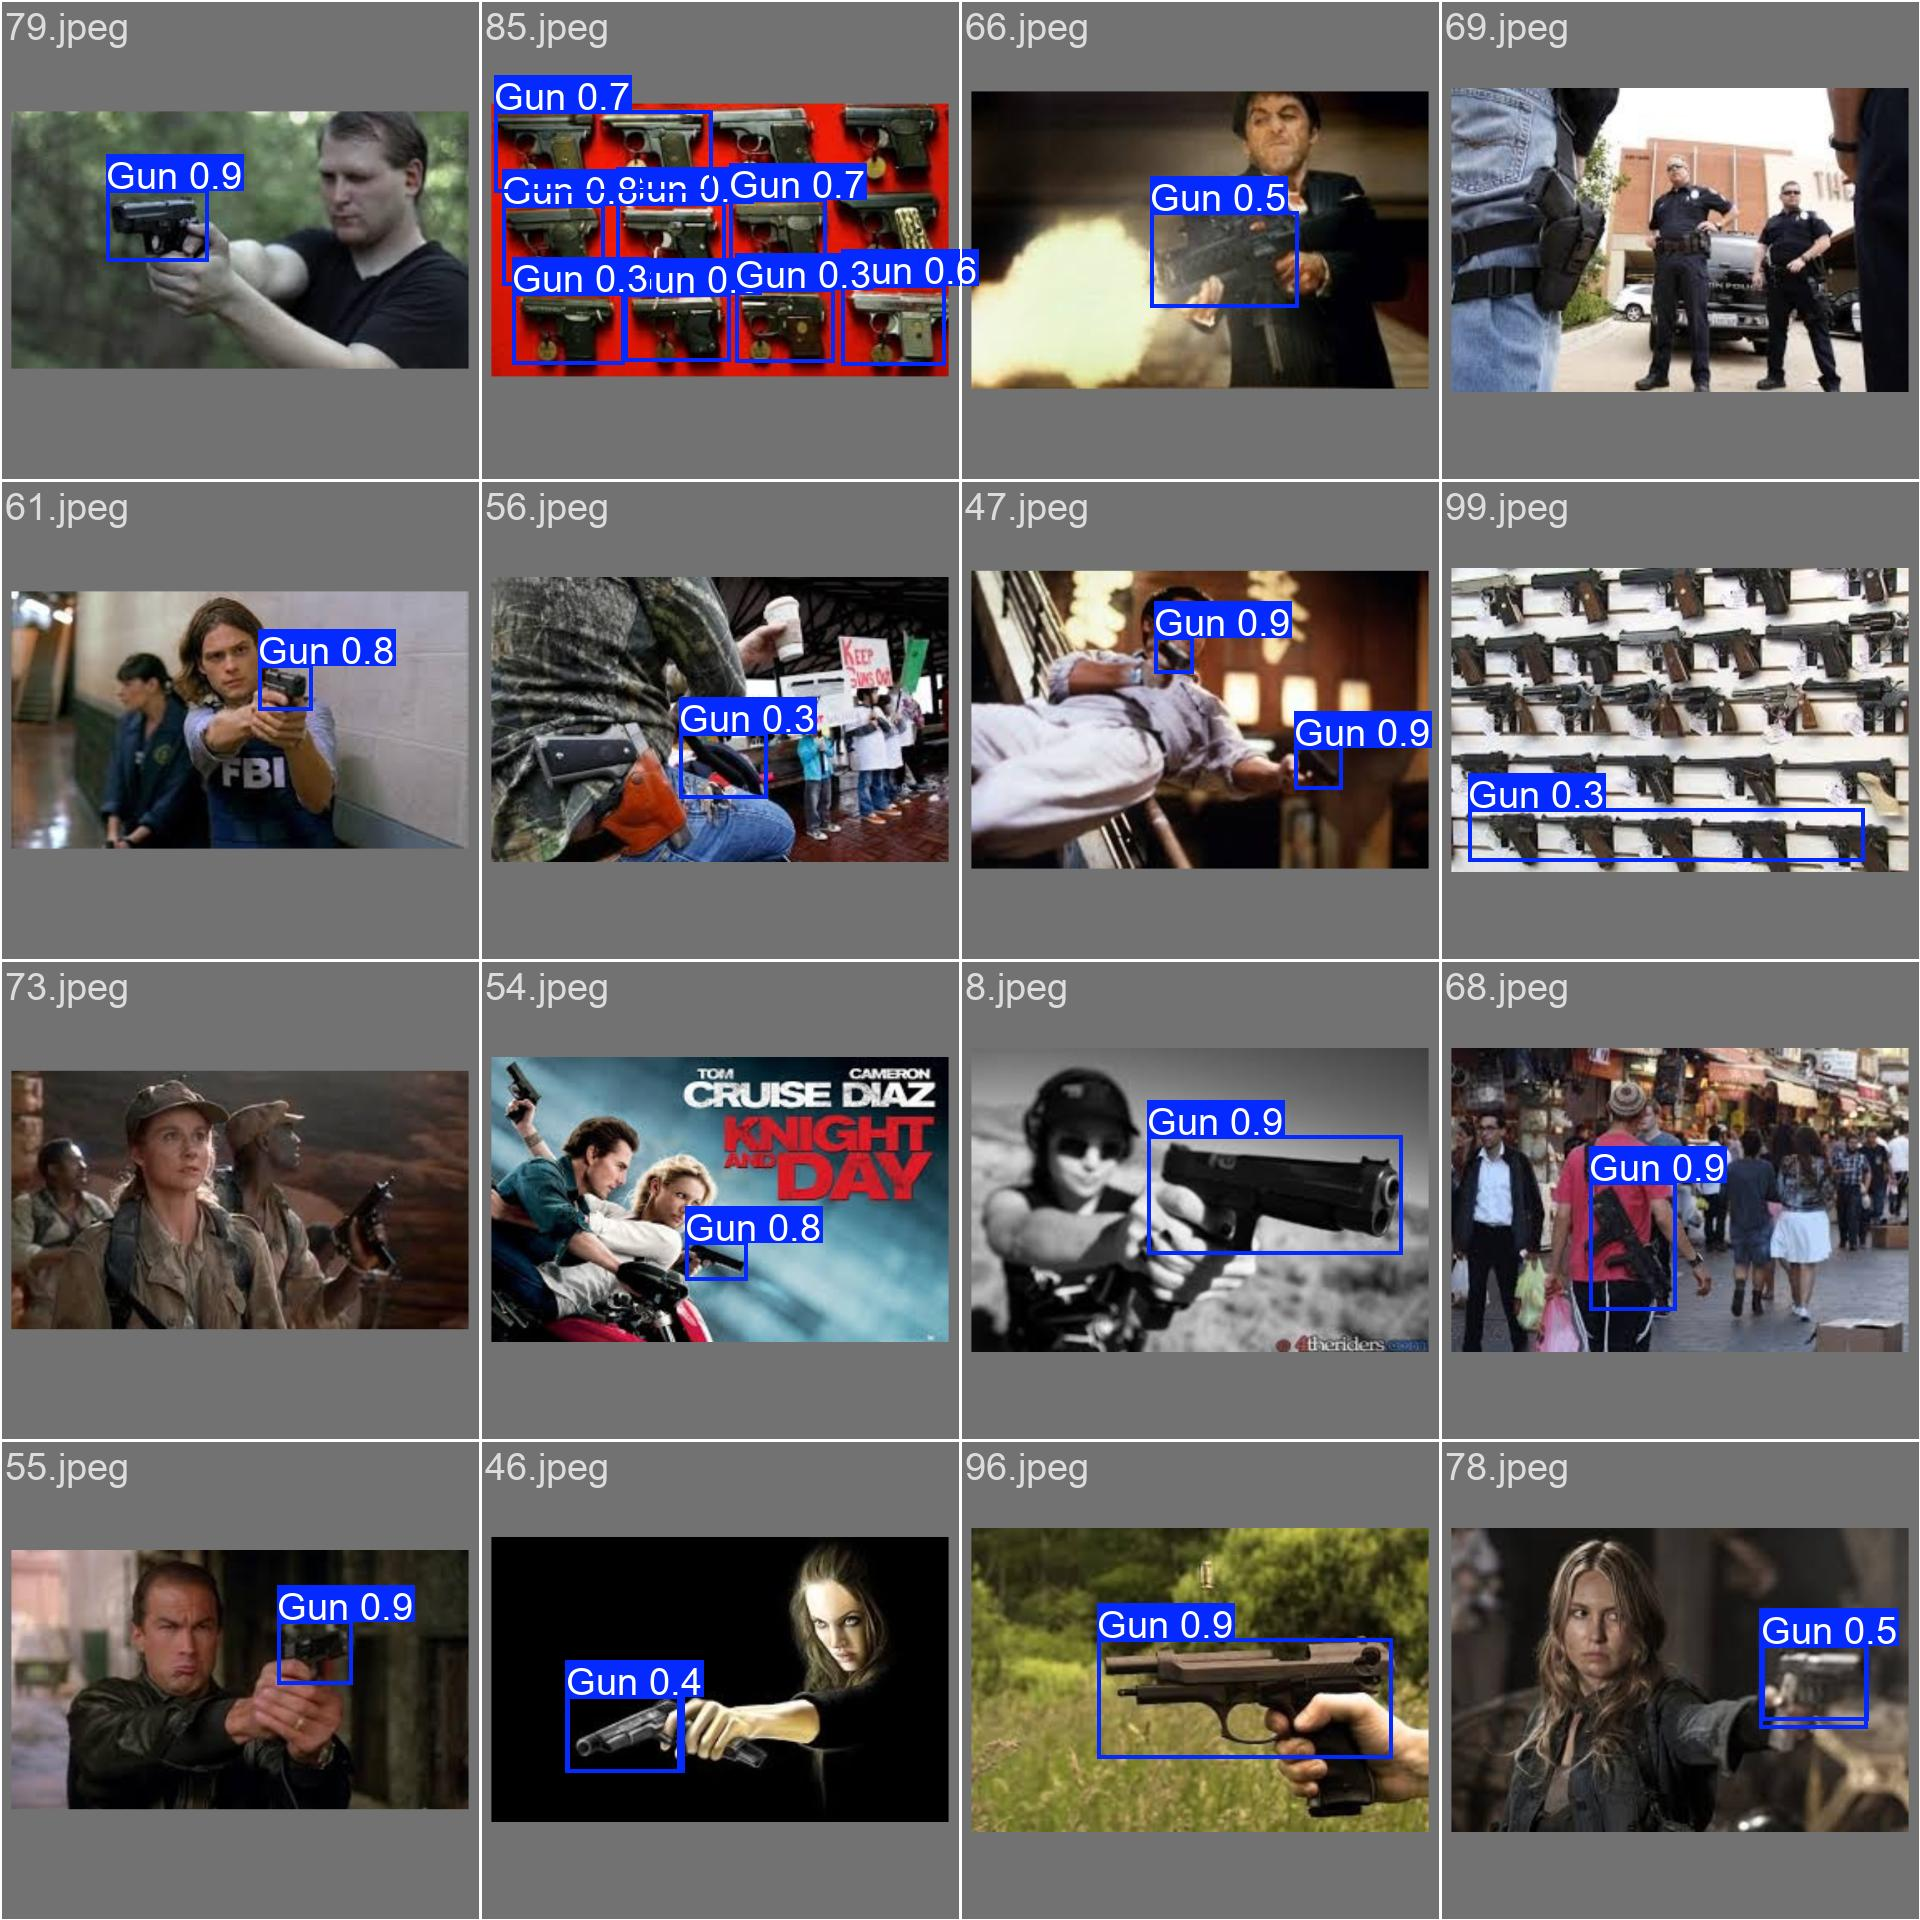

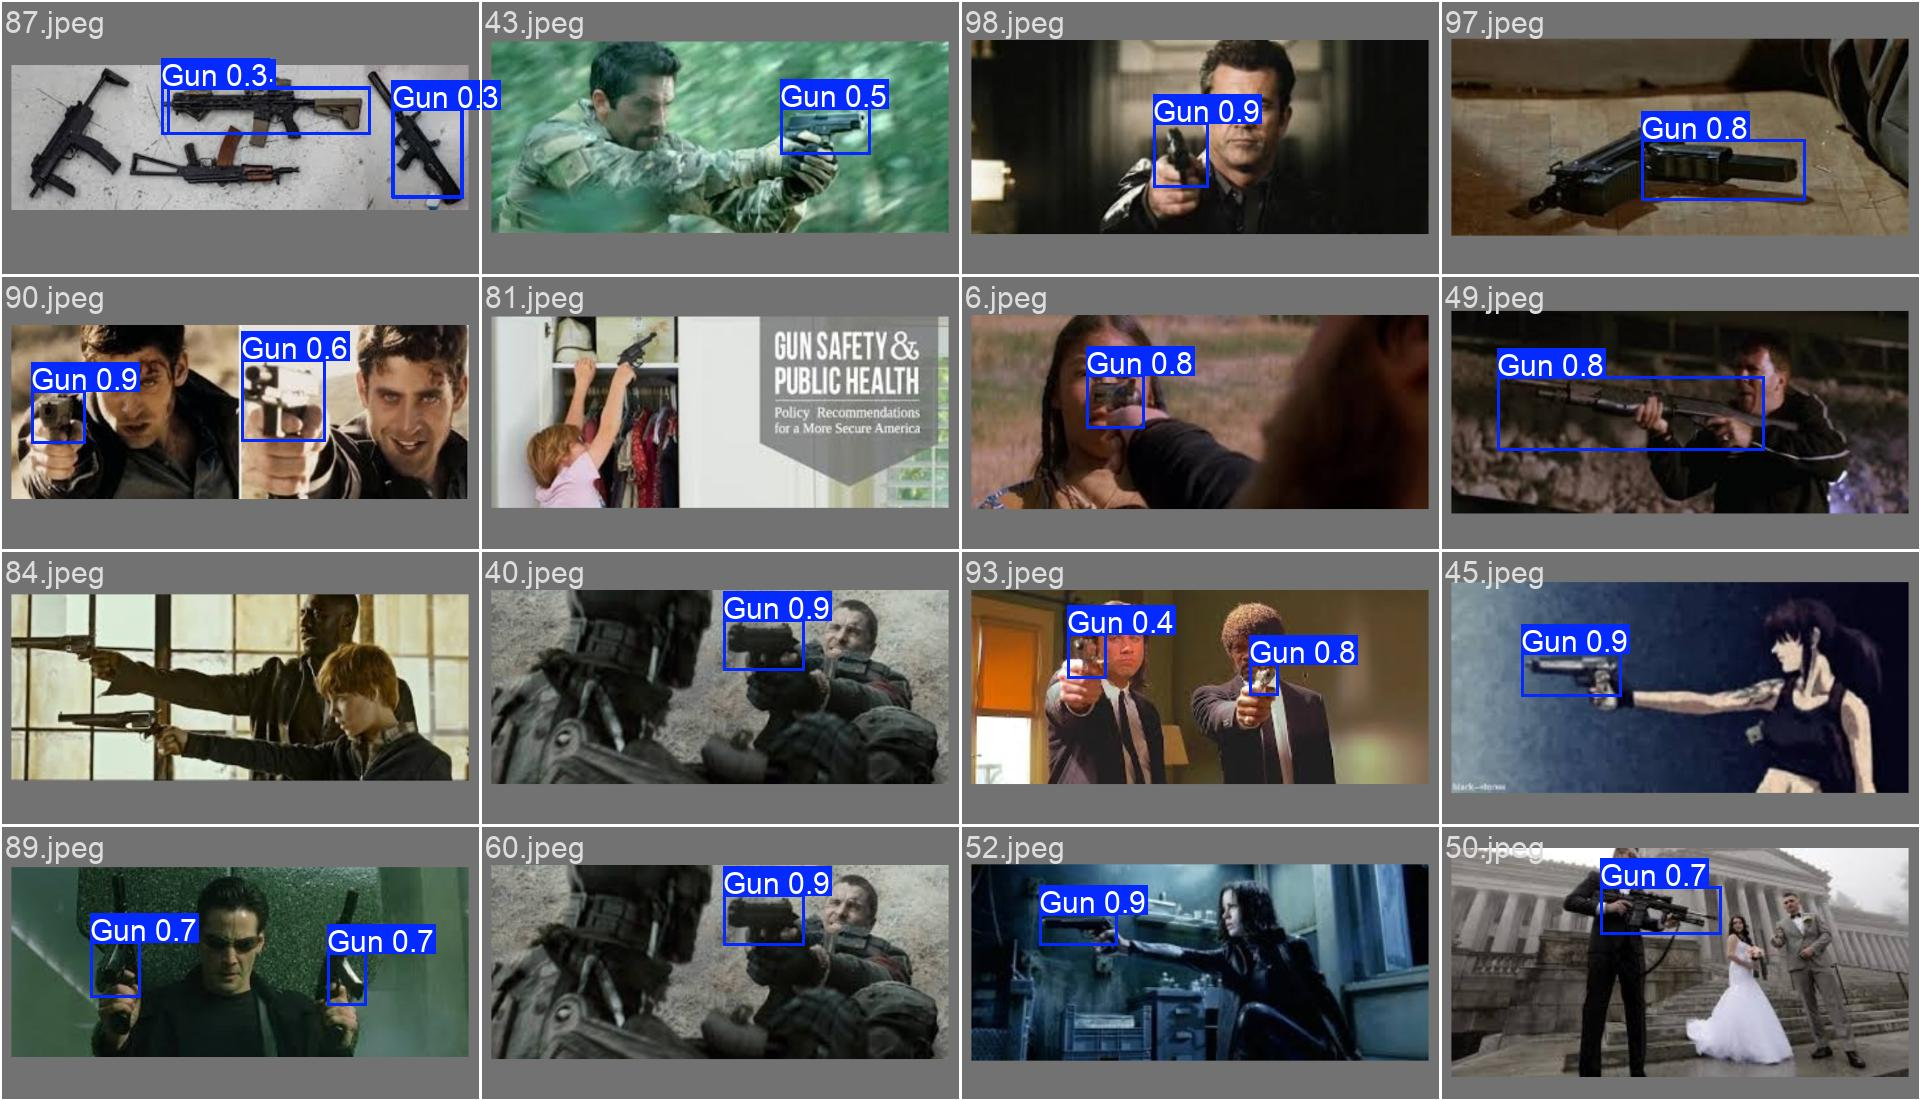

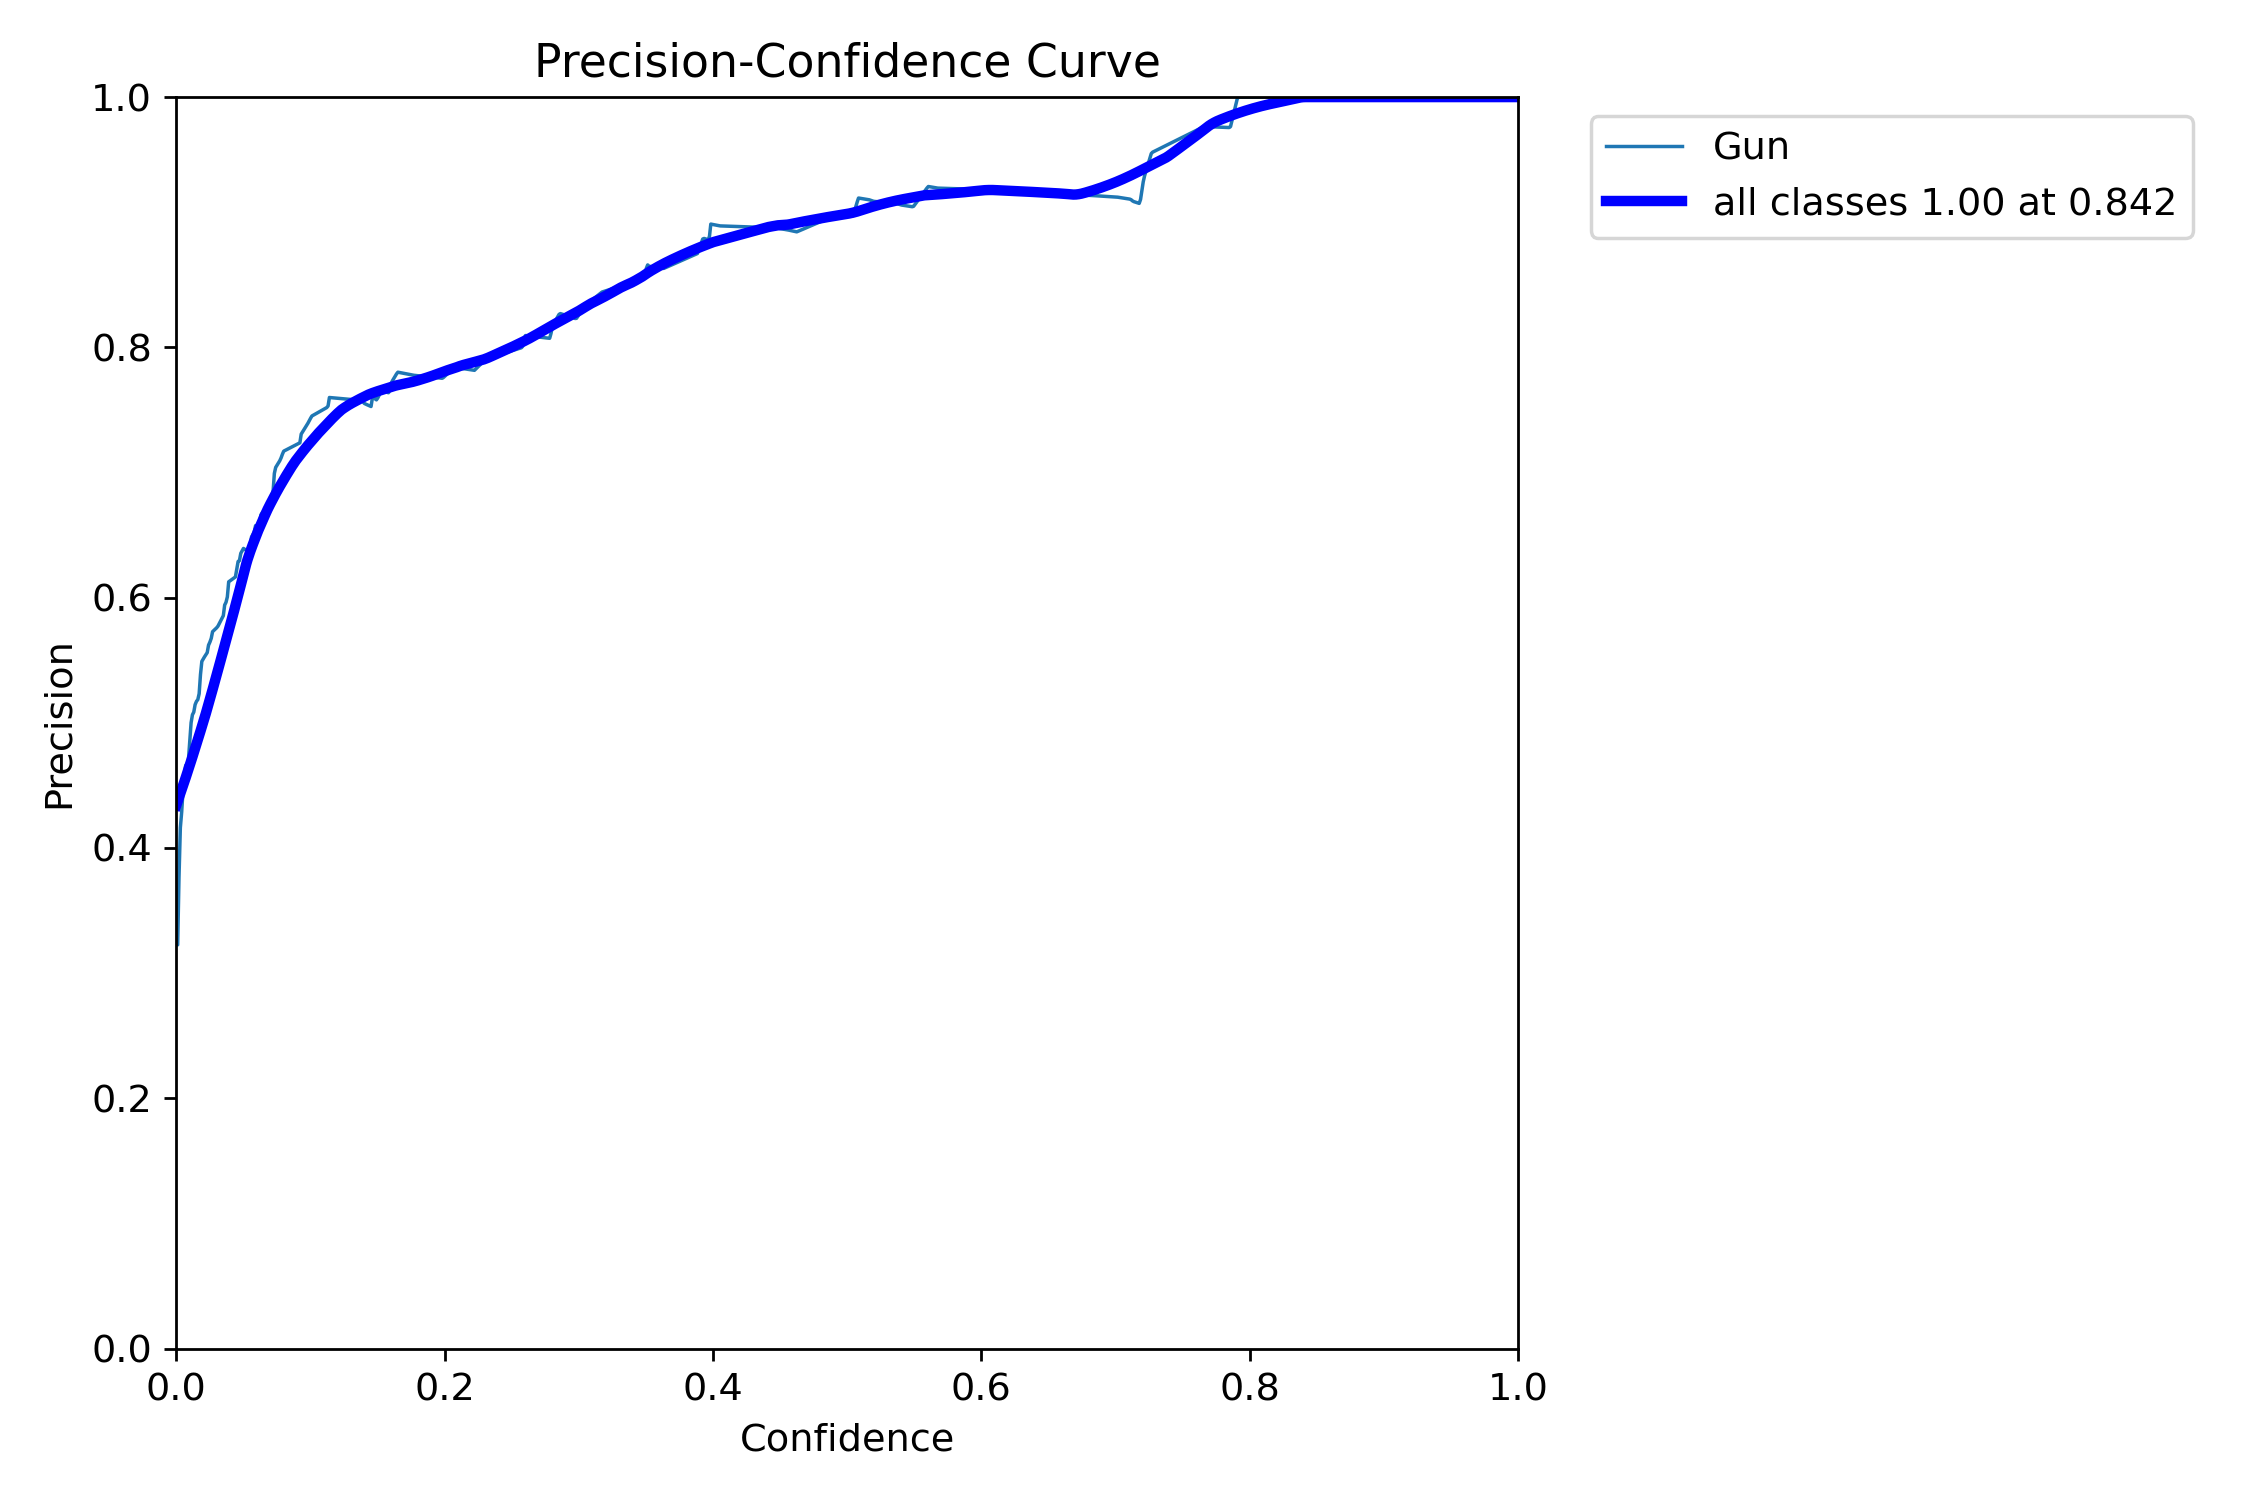

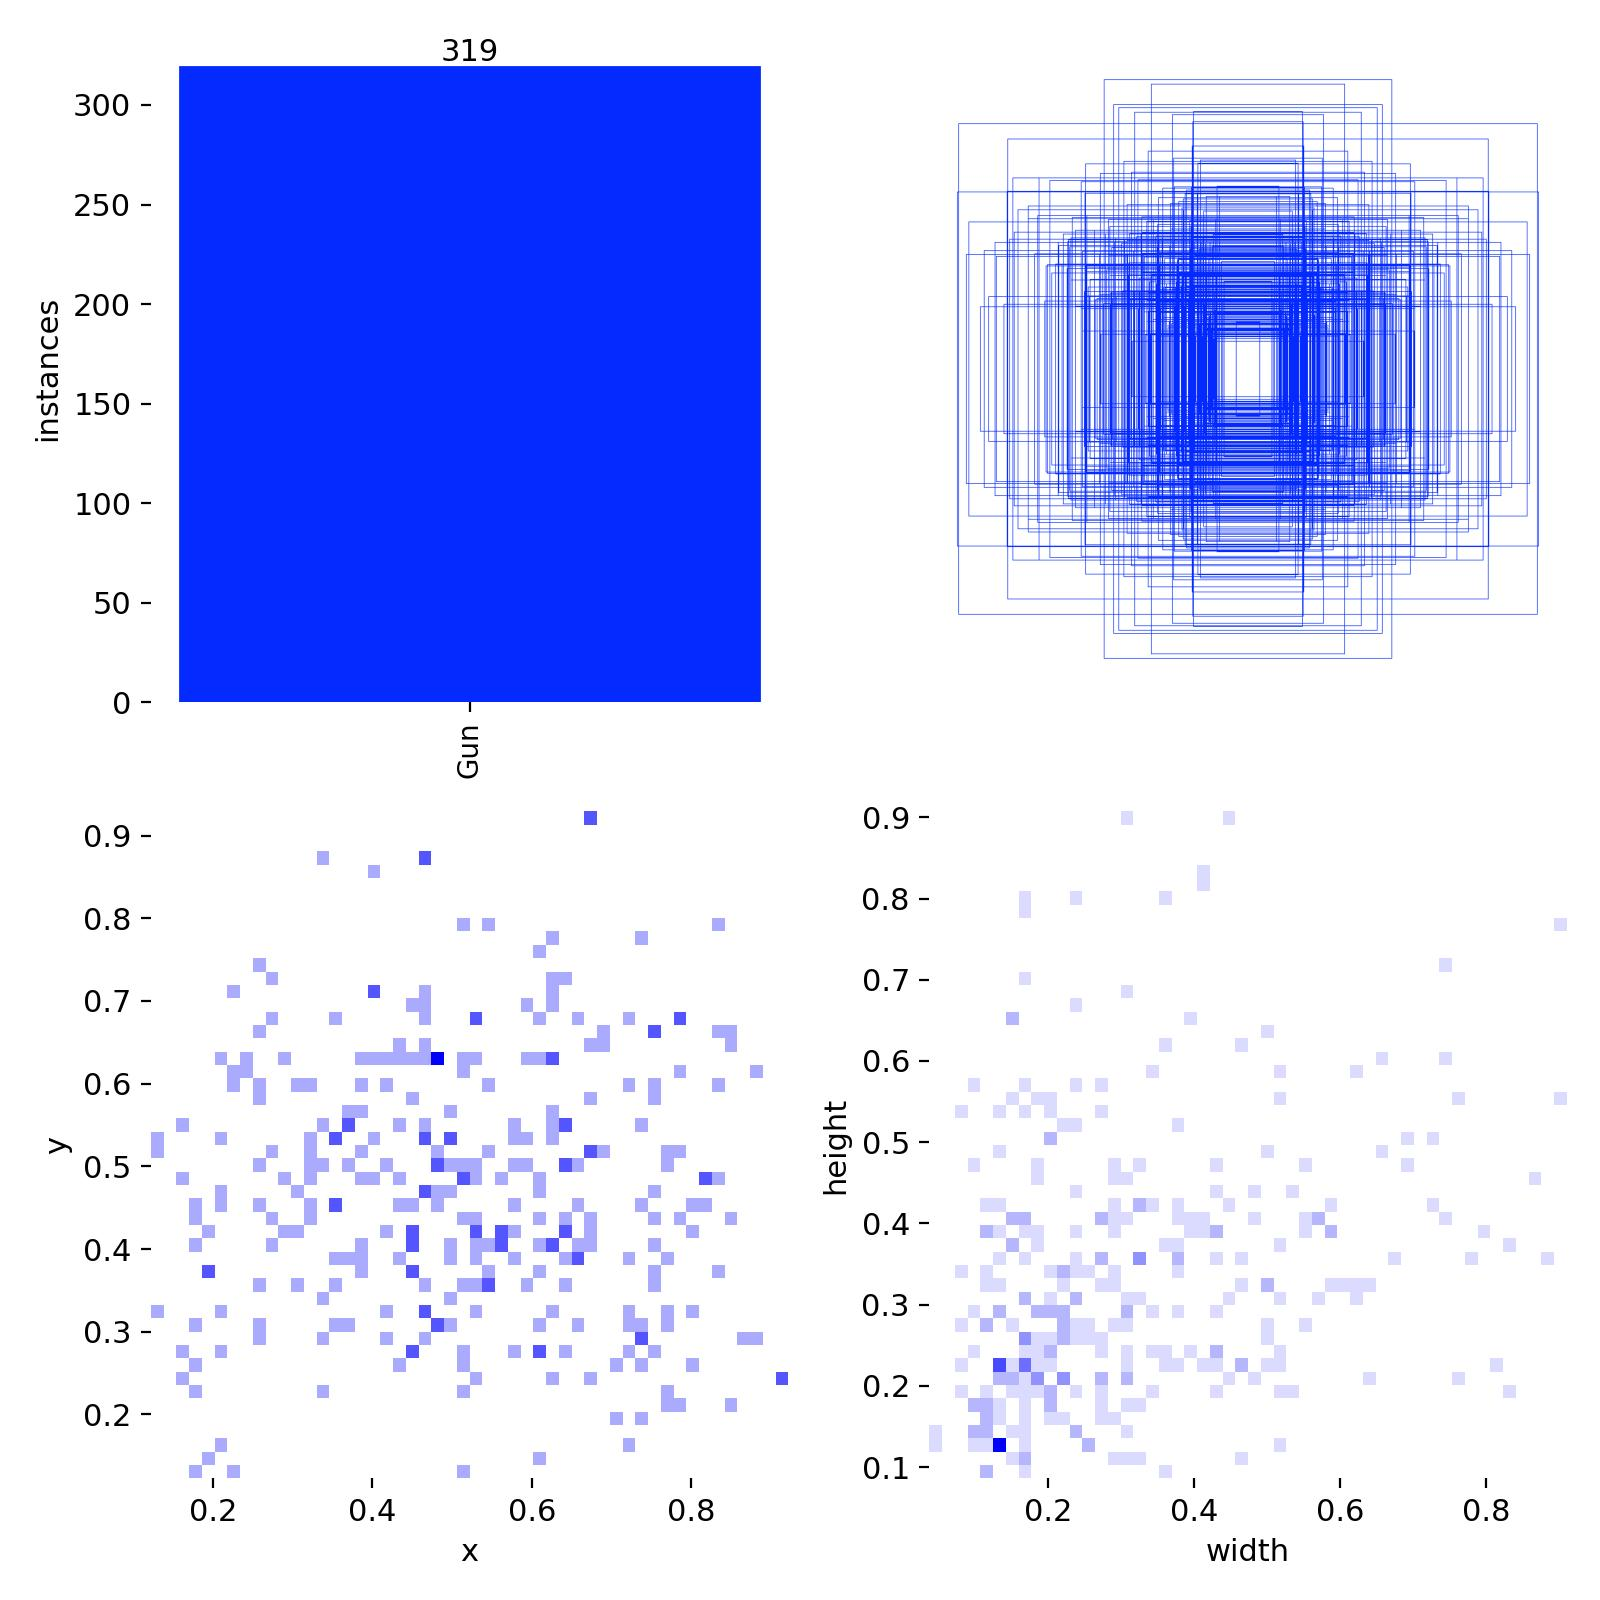

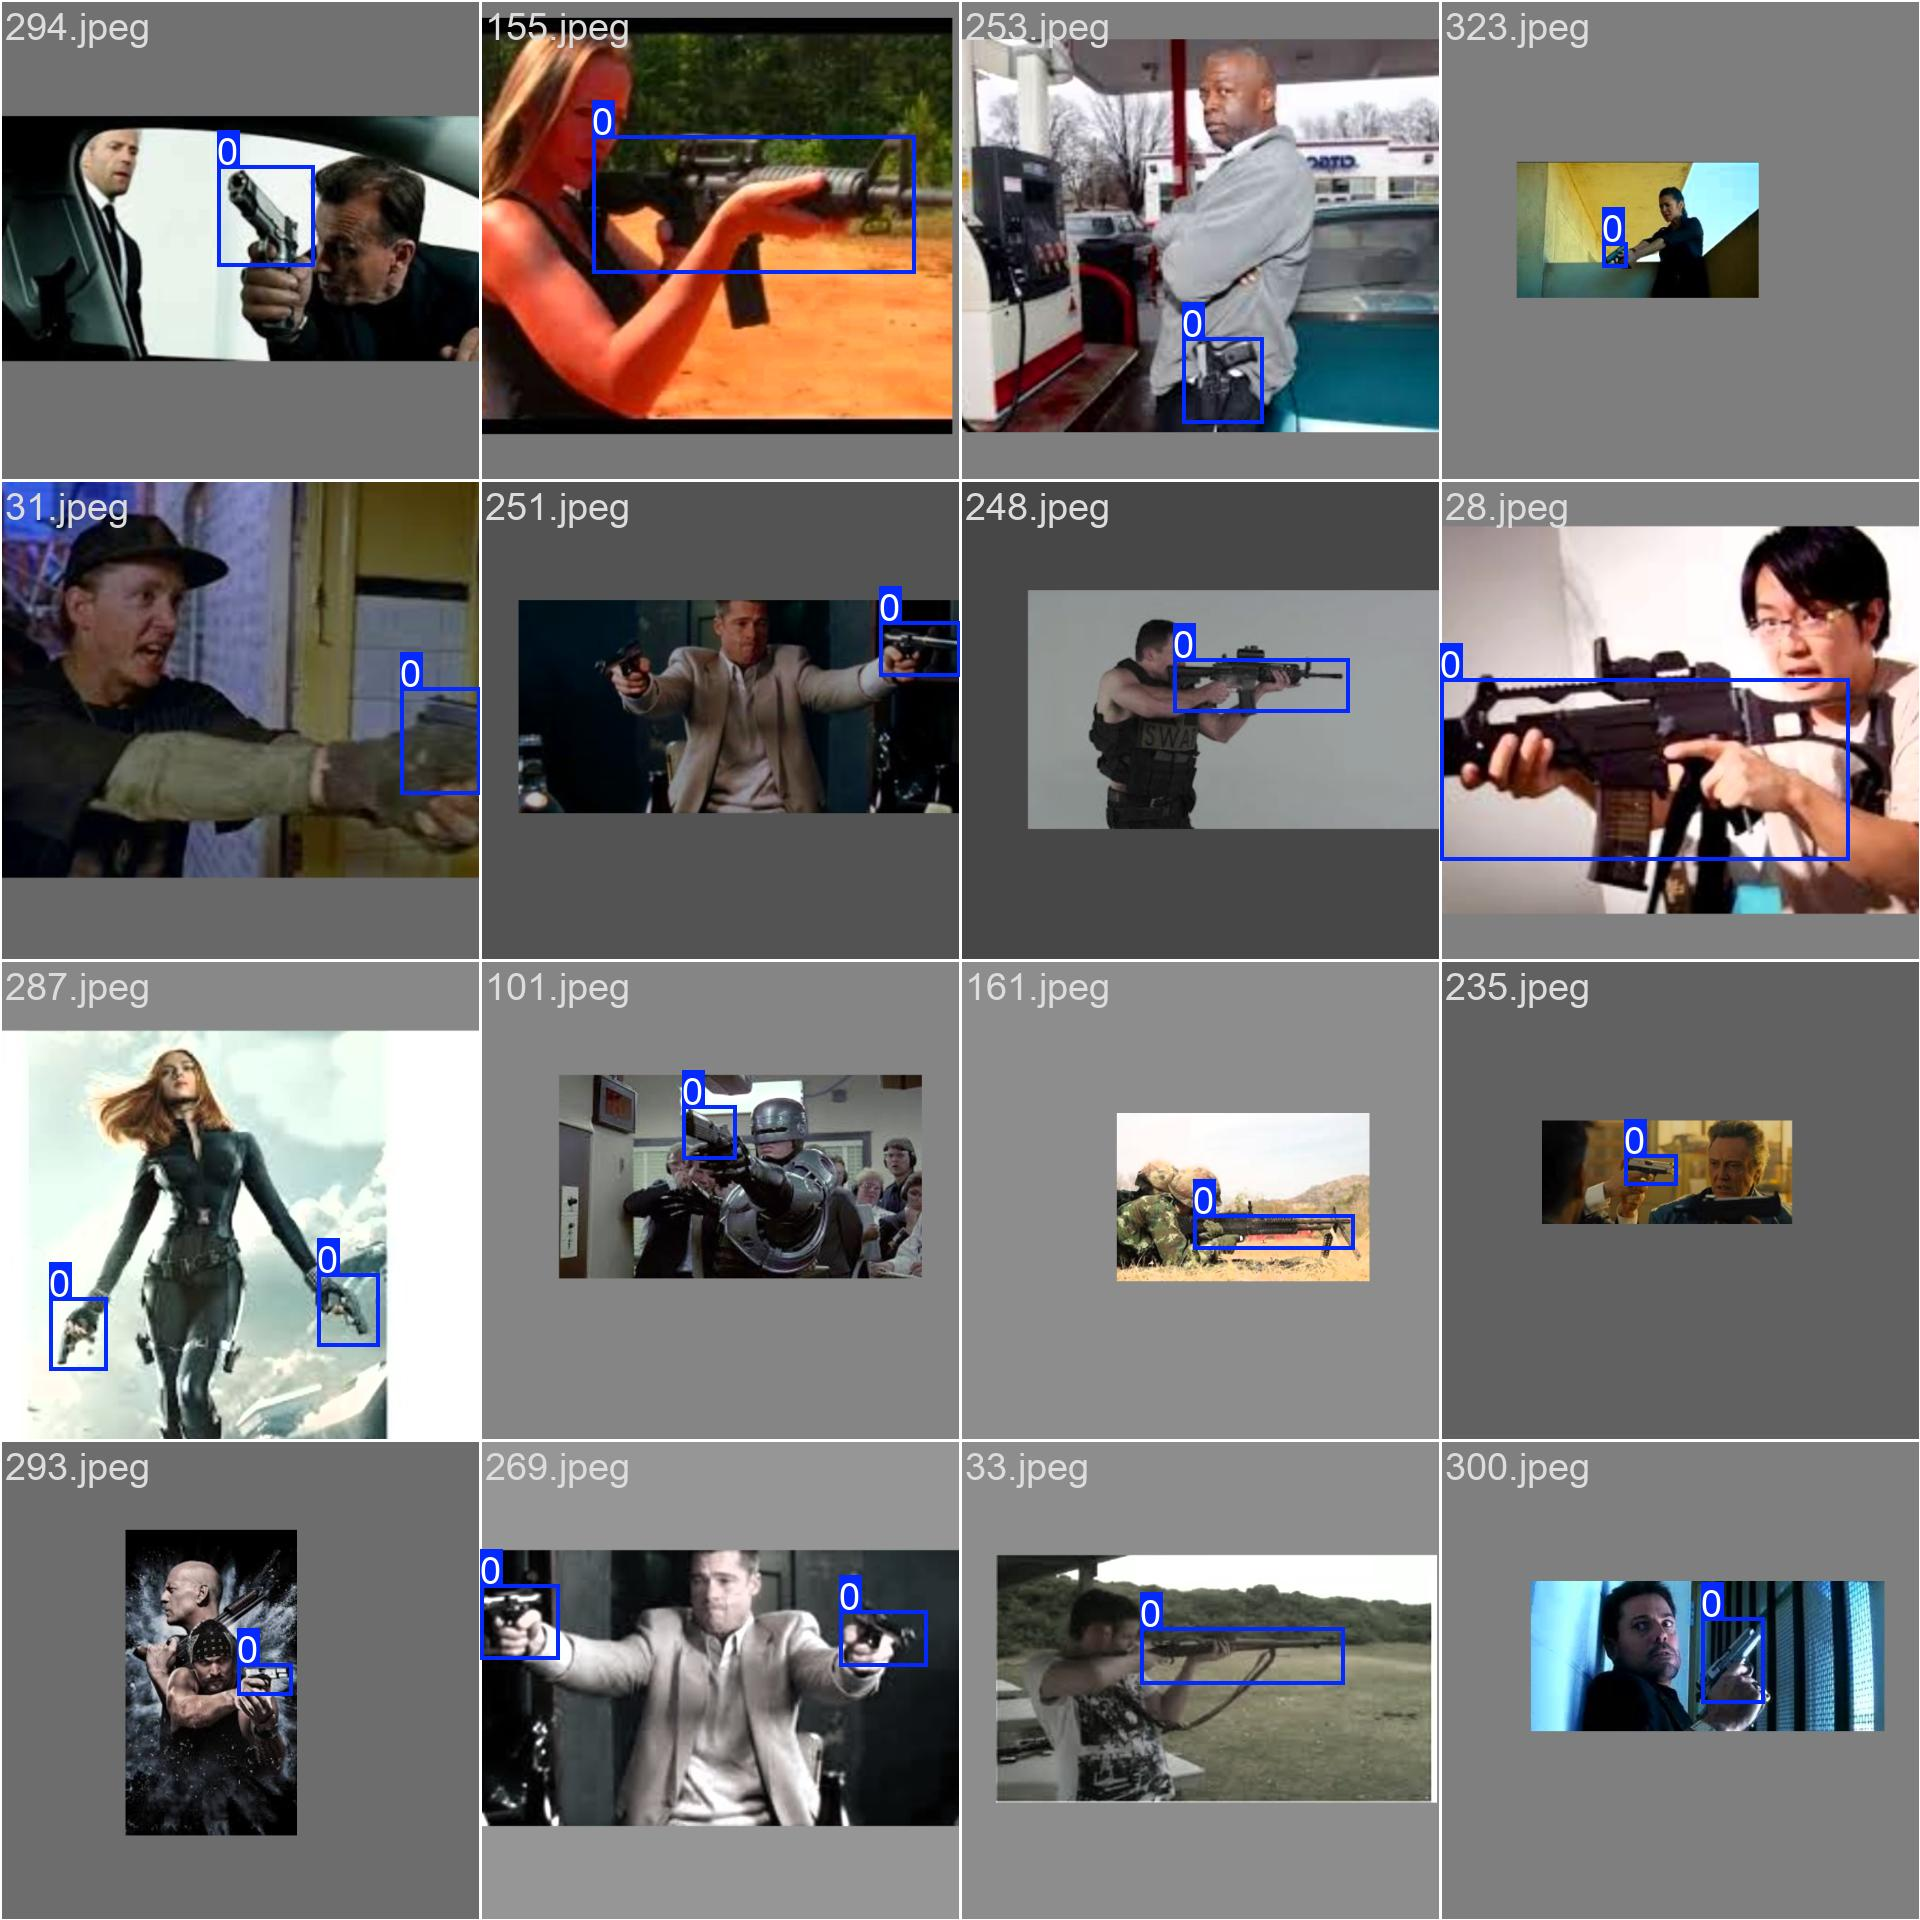

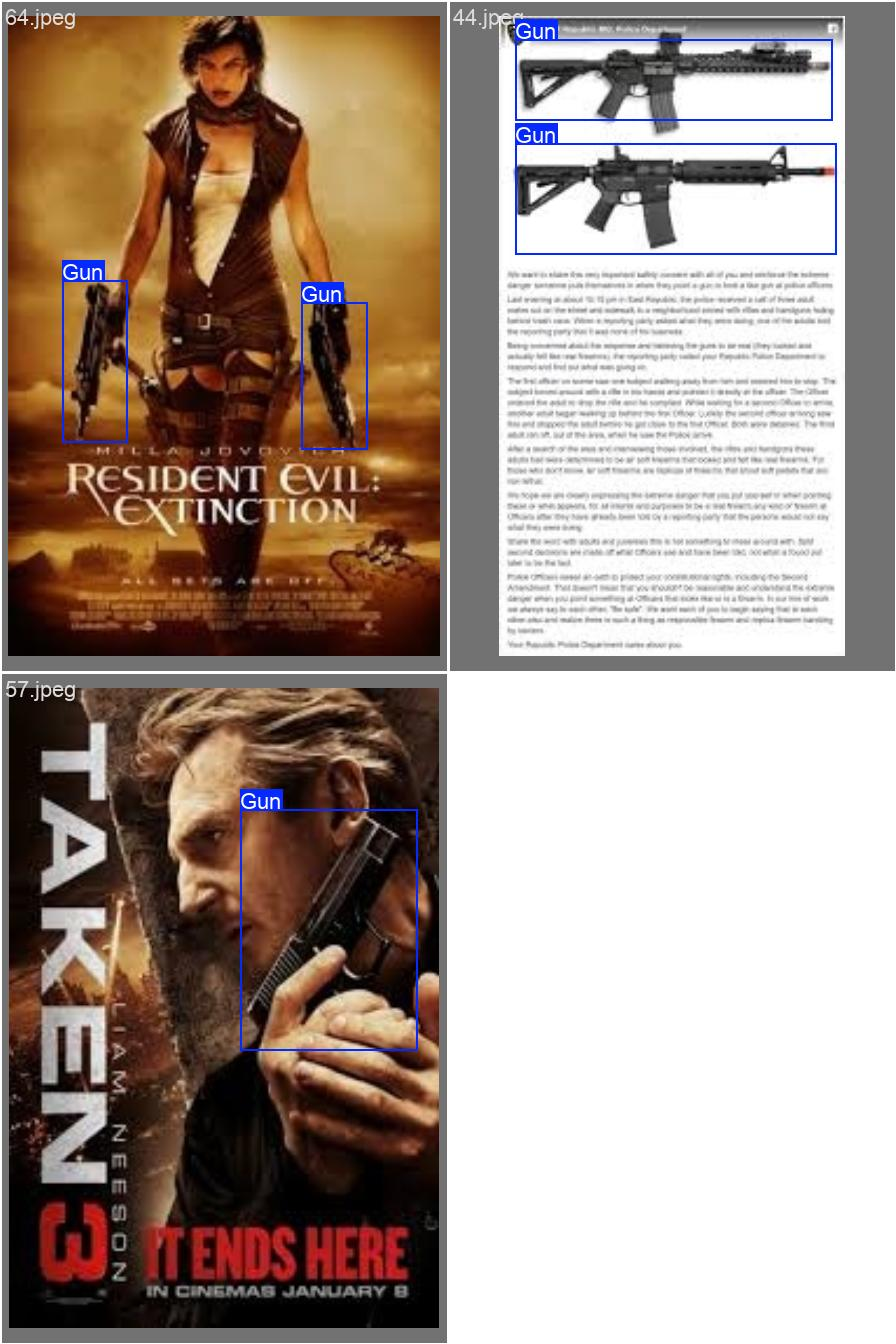

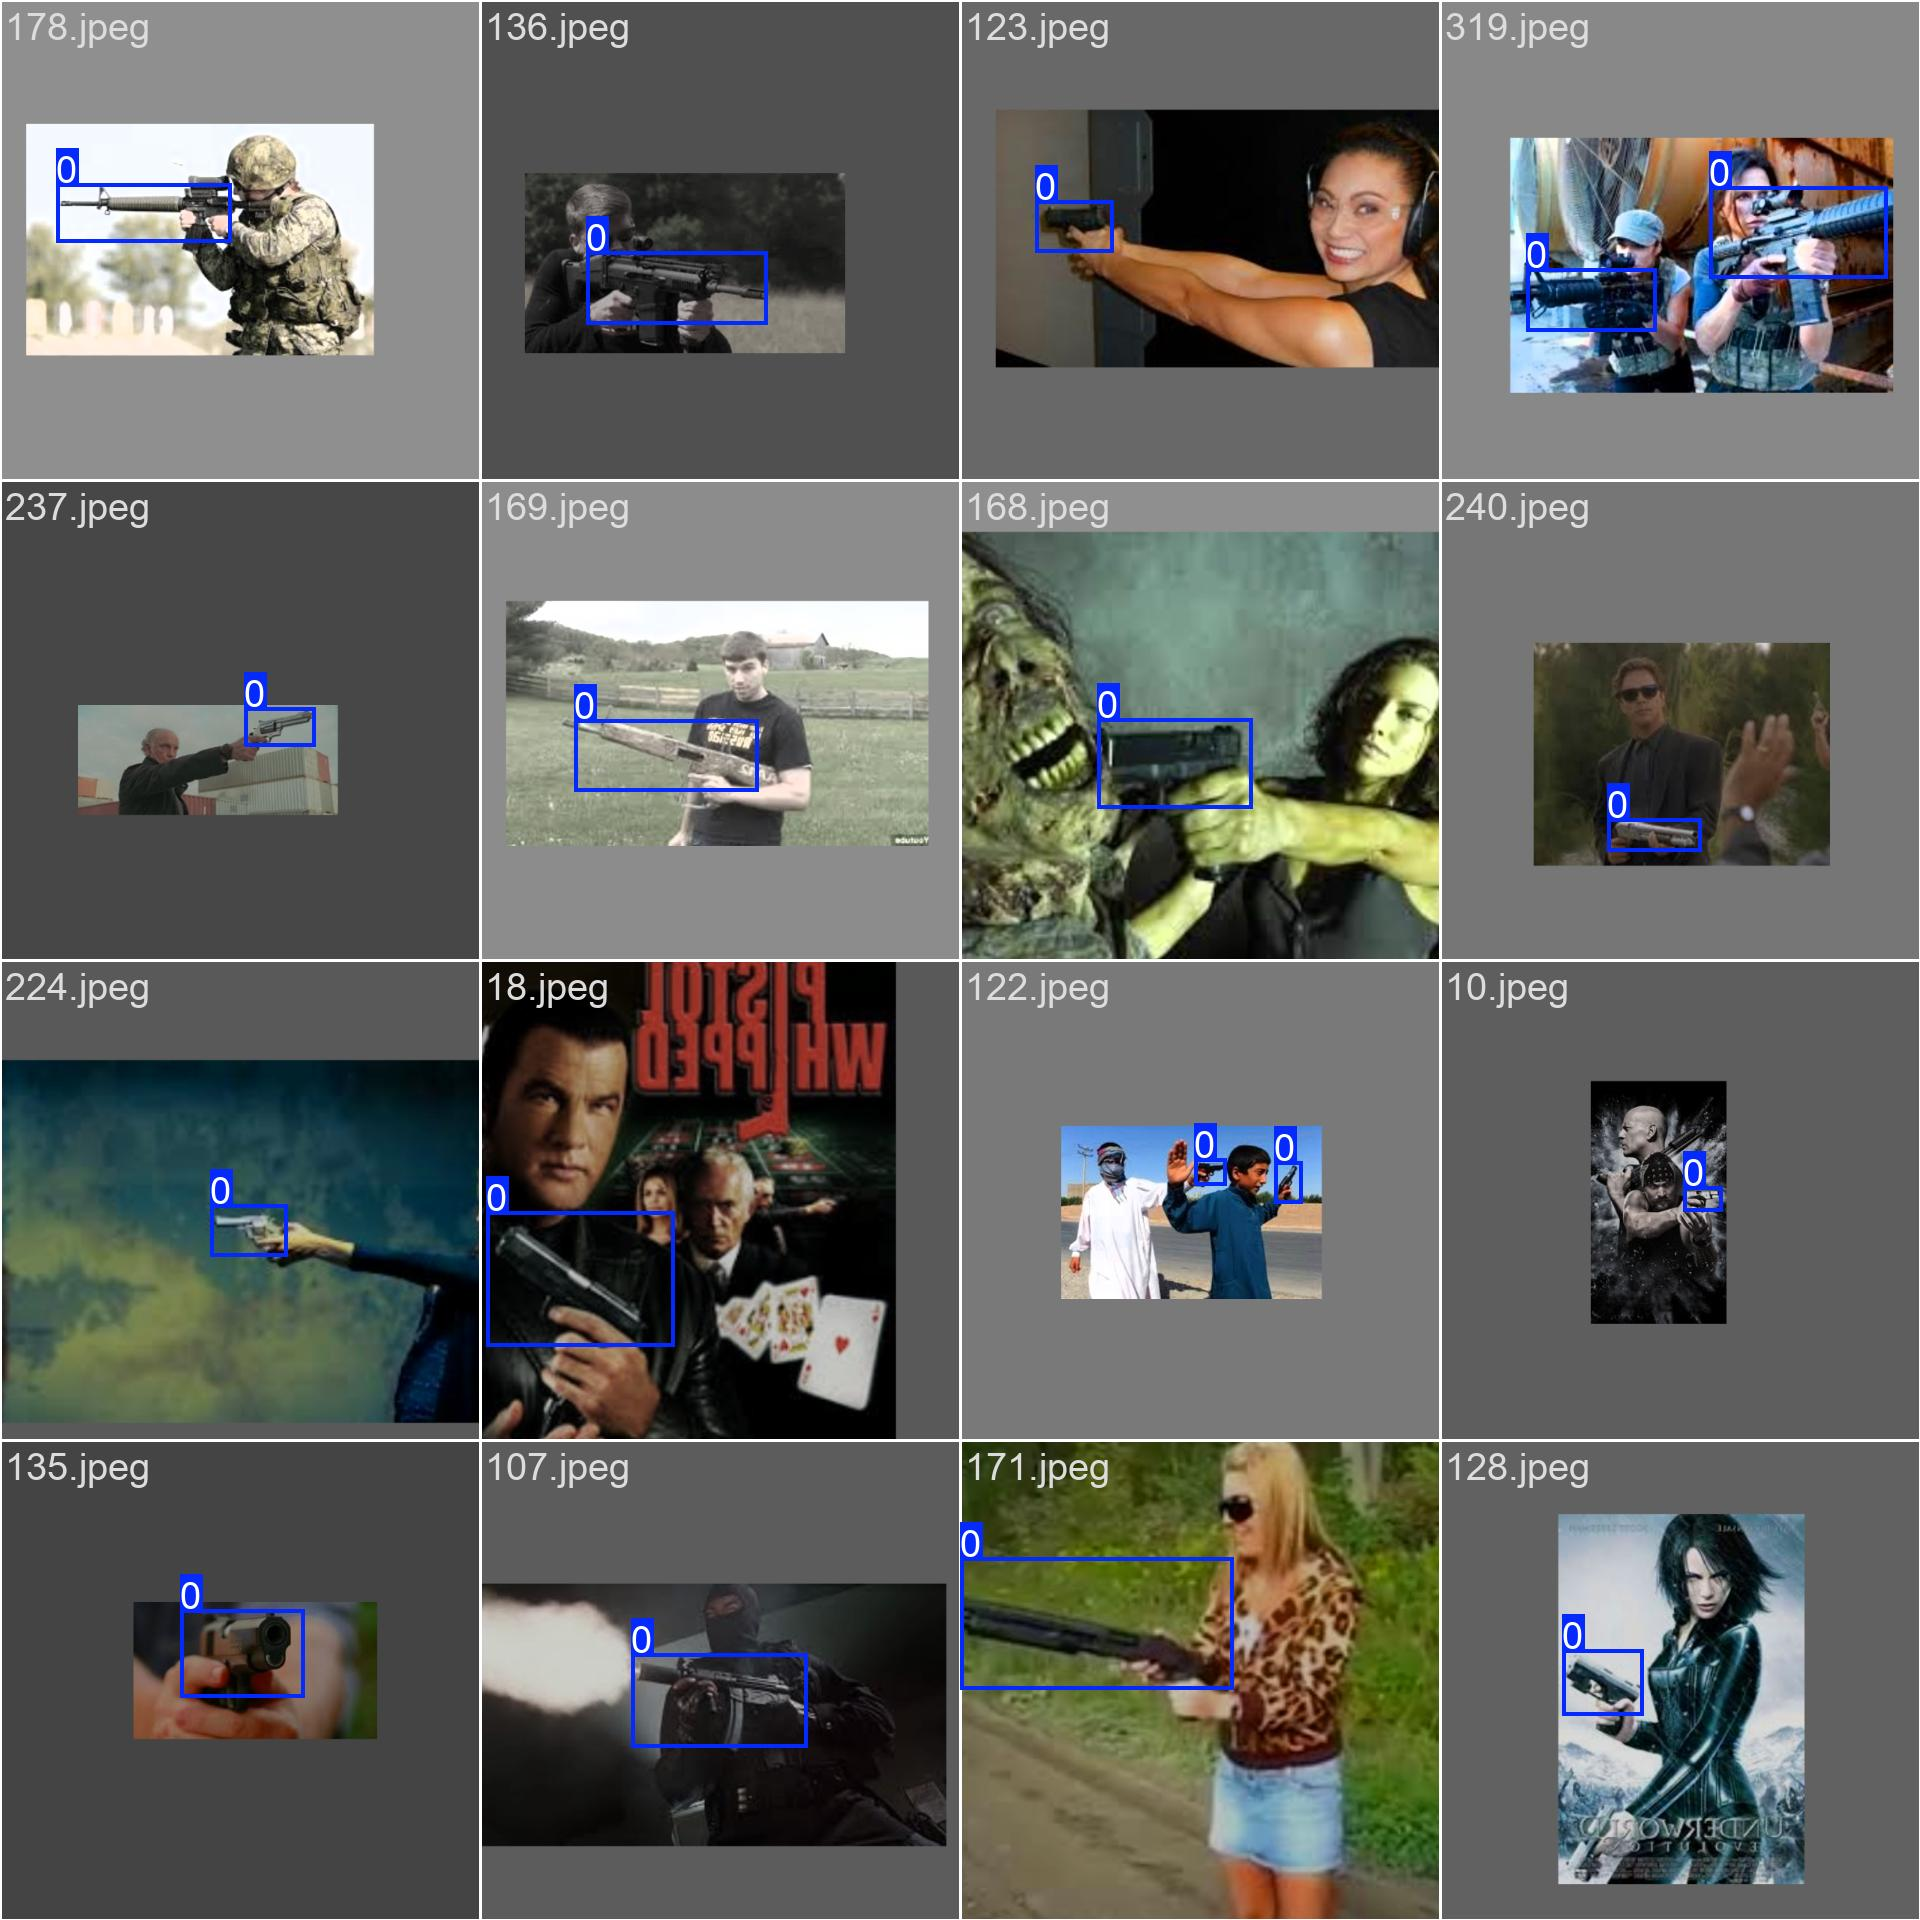

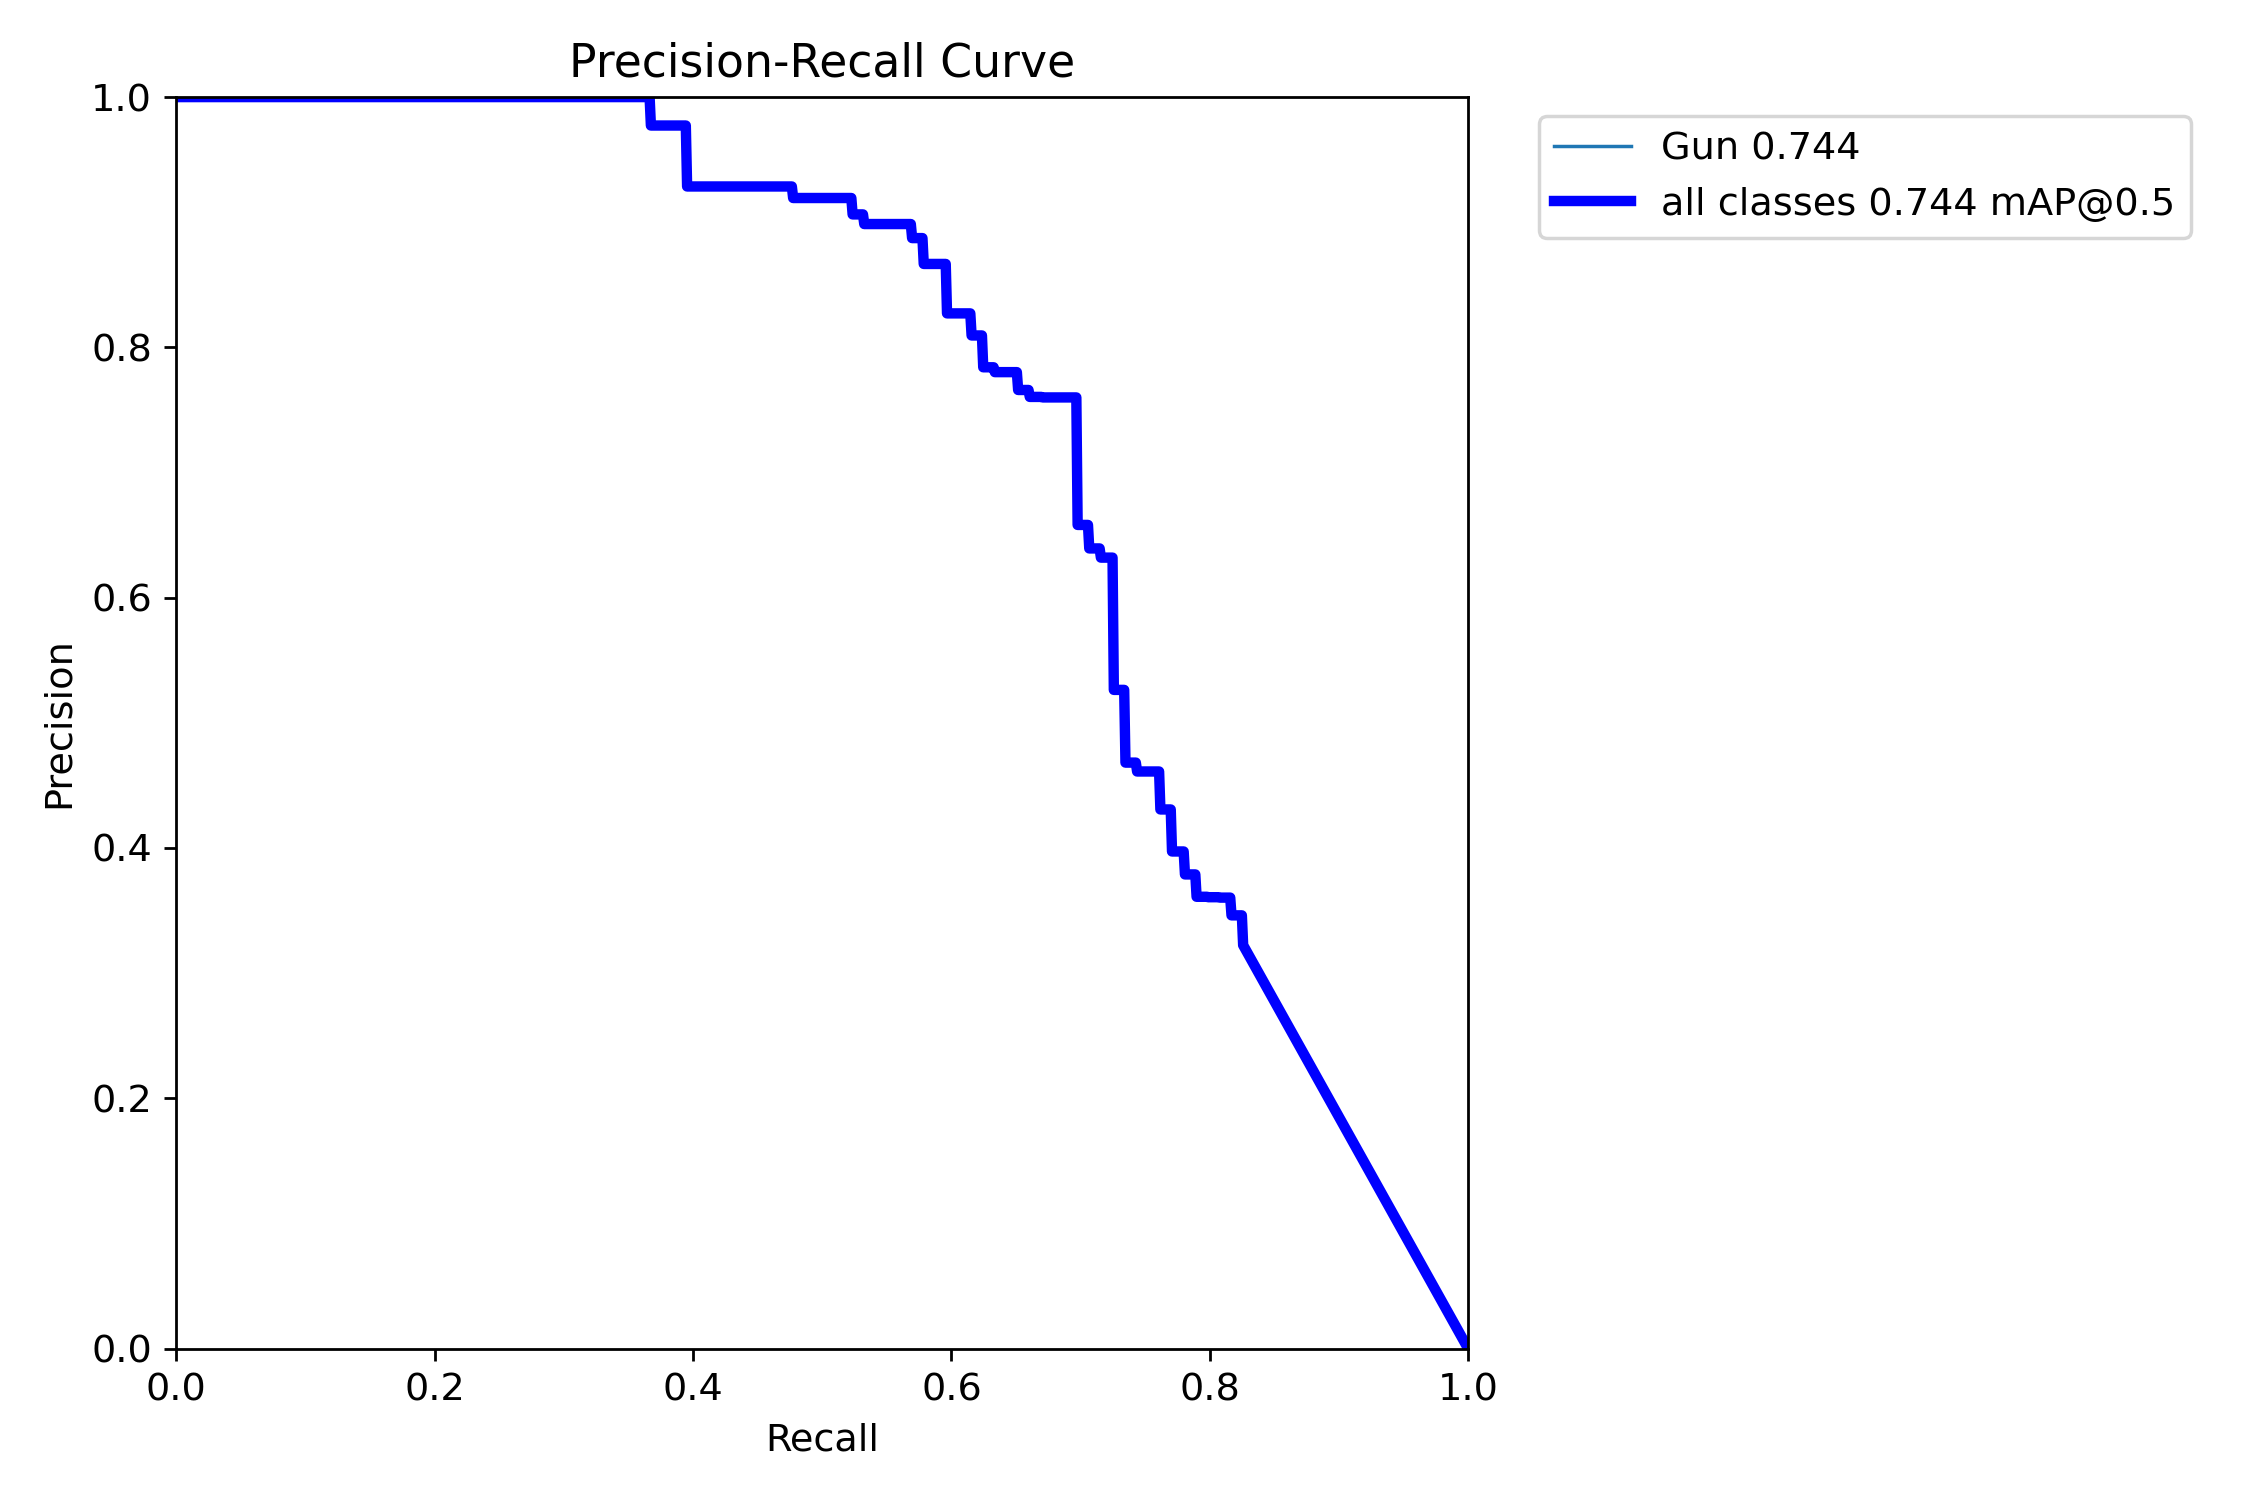

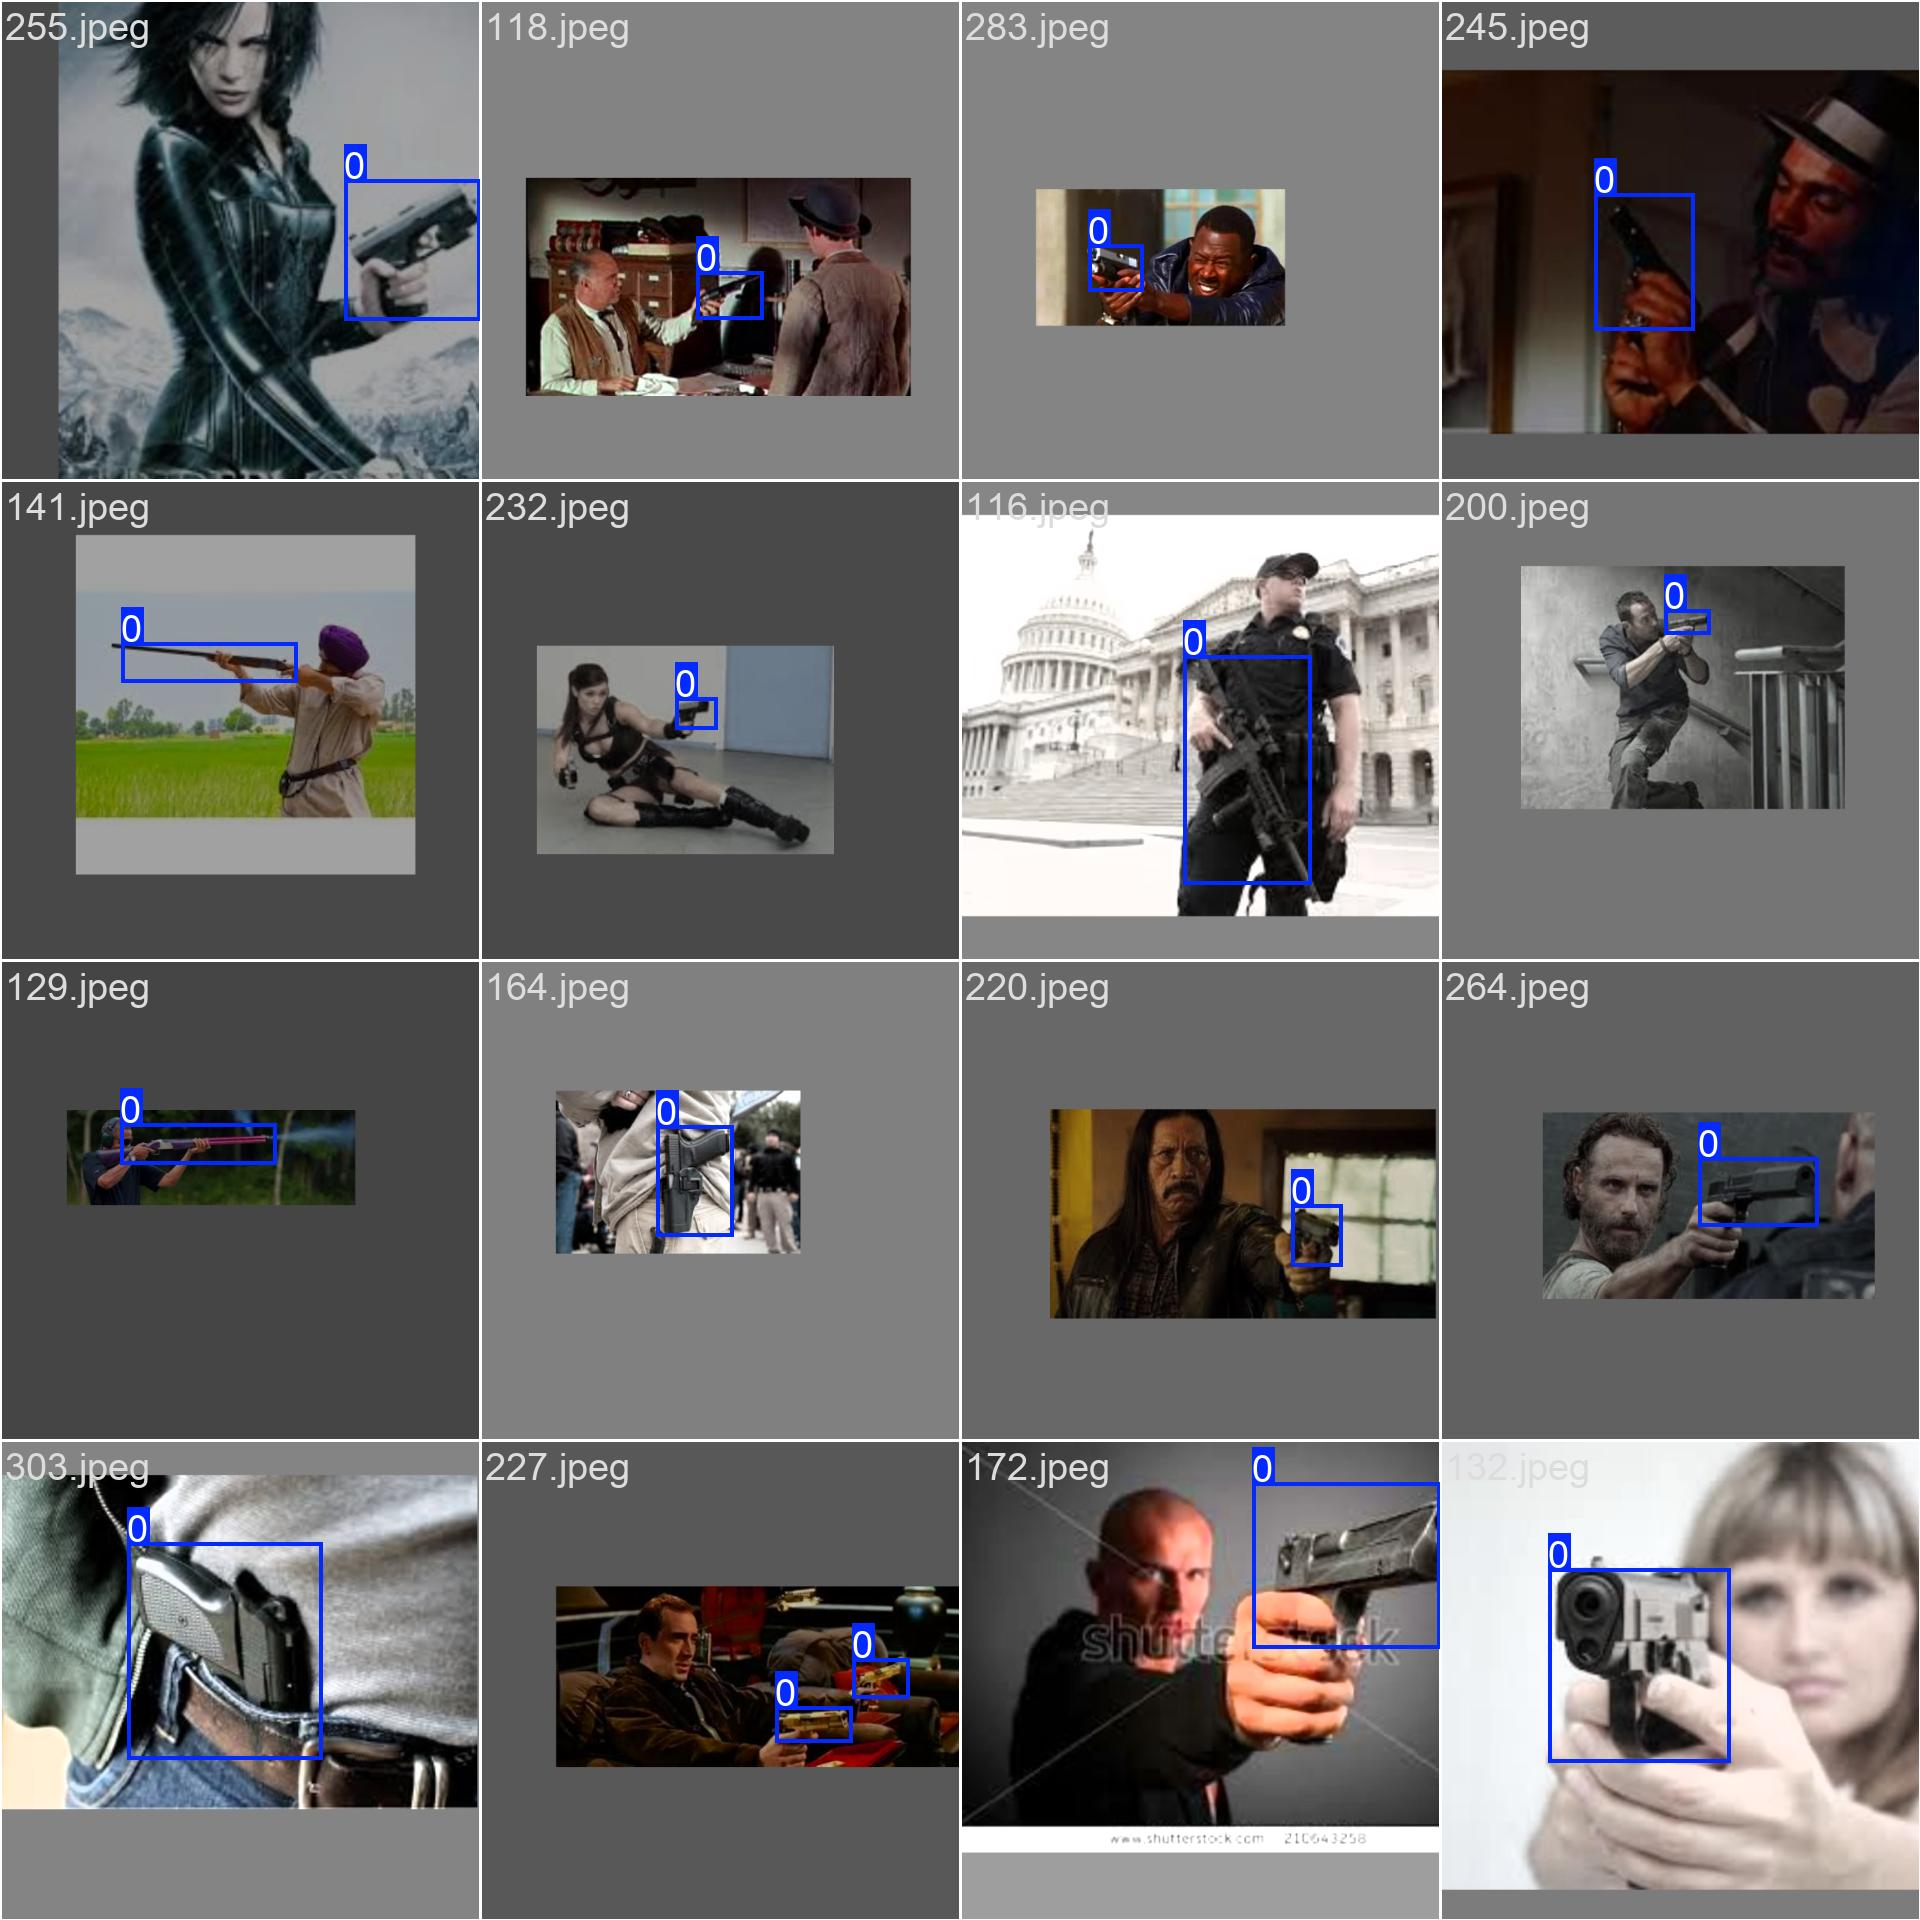

In [80]:
path = '../runs/detect/train'
image = [f for f in os.listdir(path) if f.endswith('.jpg') or f.endswith('.png')]
for i in range(len(image)):
  display(Image(filename = path + '/' + image[i]))


image 1/1 /Users/aravindrajeshmenon/Documents/DataScienceProjects/deeplearning/gun-detection/notebooks/../data/val/images/4.jpeg: 384x640 1 Gun, 469.3ms
Speed: 43.2ms preprocess, 469.3ms inference, 24.9ms postprocess per image at shape (1, 3, 384, 640)


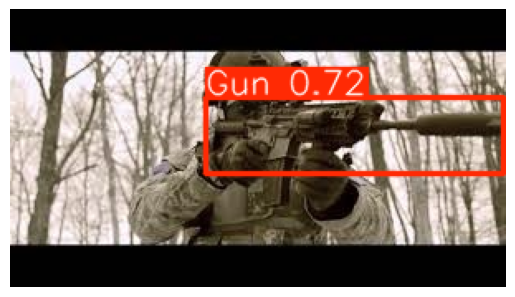

In [81]:
model = YOLO('/Users/aravindrajeshmenon/Documents/DataScienceProjects/deeplearning/object-detection/underwater-object-detection/runs/detect/train8/weights/best.pt')
results = model.predict(source = os.path.join(val_img_path, "4.jpeg"), project = '../runs/predict', name = 'test_run')

img = results[0].plot()
plt.imshow(img)
plt.axis('off')
plt.show()